<a href="https://colab.research.google.com/github/ahmed-dev-tech/Keypoints/blob/main/Keypoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.layers import *
from keras.models import *
from keras.losses import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
#sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Keypoint')
#%cd /content/gdrive/My Drive/Colab Notebooks/Keypoint
#!ls

Mounted at /content/gdrive


# Loading the data

### Data Description

Each keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 3 keypoints, which represent S', E', and A'. In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

Data files

- training.csv: list of training images. Each row contains the (x,y) coordinates for 3 keypoints, and image data as row-ordered list of pixels.
- test.csv: list of test images. Each row contains ImageId and image data as row-ordered list of pixels

In [ ]:
df = pd.read_csv('/content/TDI.csv')
df.fillna(method = 'ffill',inplace = True)
#df = pd.read_csv('/c

In [ ]:
NO_of_Images = 4000 
No_Of_Keypoints = 3 
im_w = 96 
im_h = 96 
dropped_var =  'Var7'
sigma = 5

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.

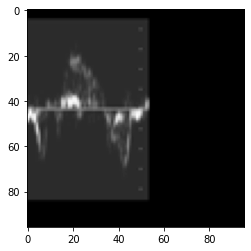

In [ ]:
#Transform the data into images and plot one to see

imgs = []
for i in range(0,NO_of_Images):
    #img = df['Image'][i].split(' ')
    img = df[dropped_var][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imgs.append(img)

image_list = np.array(imgs,dtype = 'float')
X_train = image_list.reshape(-1,im_w, im_h,1)
print(X_train)
print(X_train.shape)
X_train = np.transpose(X_train,(0,2,1,3)) # The Convolution2D layers in Keras are designed to work with 3 dimensions per sample. They have 4-dimensional inputs and outputs. This covers colour images (nb_samples, nb_channels, width, height)
print(X_train)
print(X_train.shape)
plt.imshow(X_train[0].reshape(im_w, im_h),cmap='gray')
plt.show()

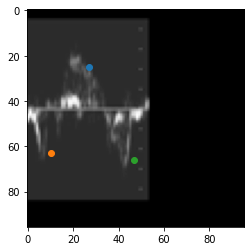

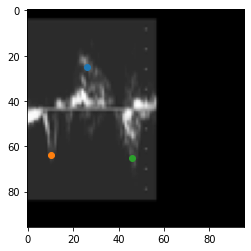

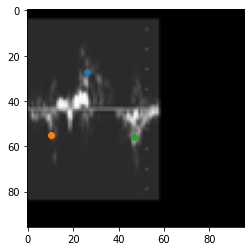

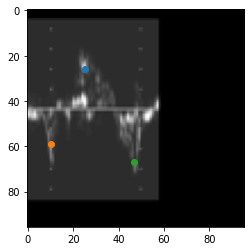

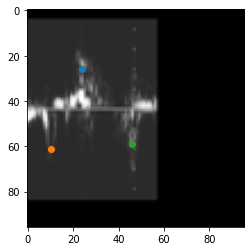

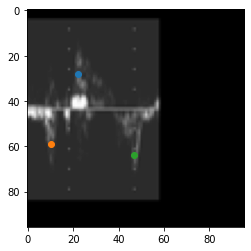

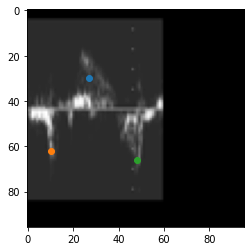

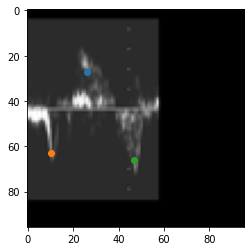

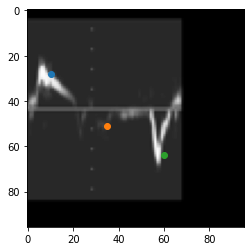

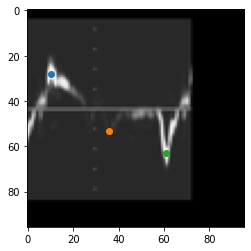

In [ ]:
#Get the keypoint labels
#training = df.drop('Image',axis = 1)
training = df.drop(dropped_var,axis = 1)

y_train = []
for i in range(0,NO_of_Images):
    y = training.iloc[i,:]

    y_train.append(y[0:No_Of_Keypoints*2])
y_train = np.array(y_train,dtype = 'float')

#Plot labels ontop of image
for sample_no in range(0, 10):
  img = X_train[sample_no].copy()
  for i in range(0, len(y_train[sample_no])-1, 2):
      x = int(y_train[sample_no][i])
      y = int(y_train[sample_no][i+1])
      plt.scatter(x,y)
  plt.imshow(img.reshape(im_w, im_h),cmap='gray')
  plt.show()

In [ ]:
print(y_train.shape)

(4000, 6)


In [ ]:
No_Of_Keypoints

3

# Creating the Heatmaps

The model will be predicting heatmaps. To get labelled heatmap data, pass the Cartesian coordinates through a 2D gaussian kernel.

In [ ]:
#Function to create heatmaps by convoluting a 2D gaussian kernel over a (x,y) keypoint.
def gaussian(xL, yL, H, W, sigma=5):

    channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
    channel = np.array(channel, dtype=np.float32)
    channel = np.reshape(channel, newshape=(H, W))

    return channel

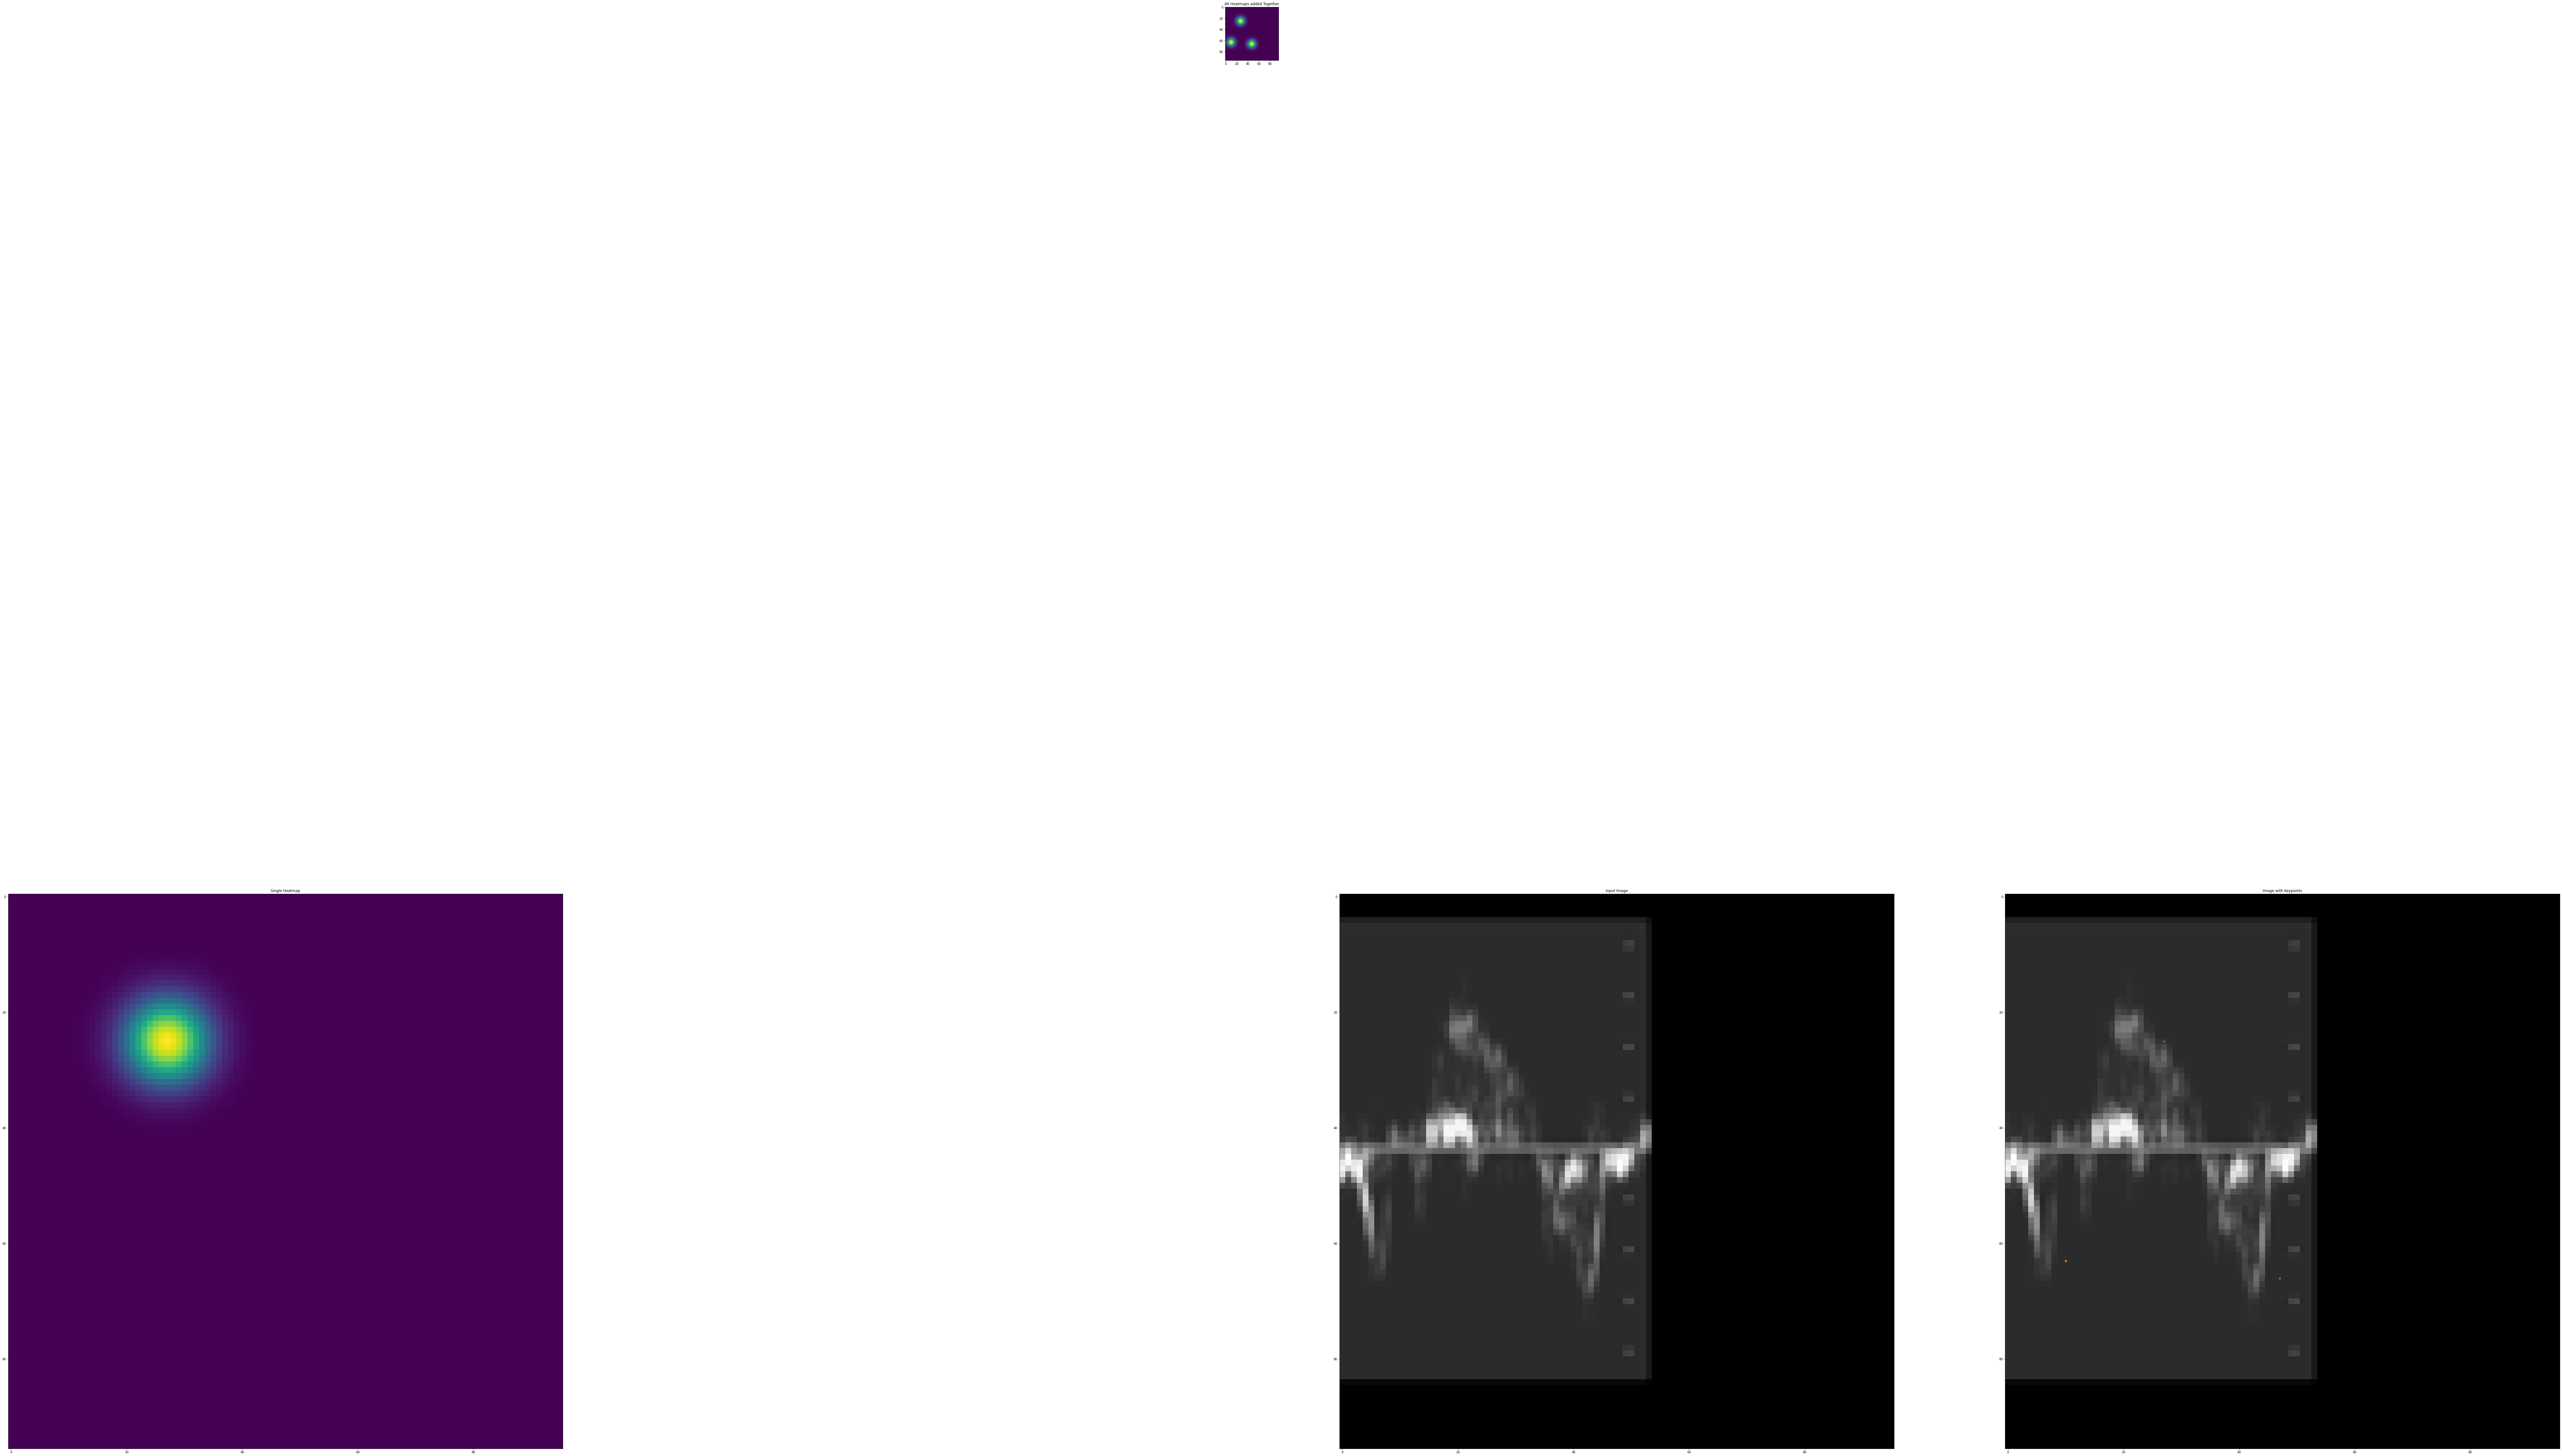

(3, 96, 96)

In [ ]:
#Generate heatmaps for one sample image
heatmaps = []

for i in range(0, No_Of_Keypoints*2, 2):
    x = int(y_train[0][i])
    y = int(y_train[0][i + 1])
    heatmap = gaussian(x, y, im_h, im_w, sigma)
    heatmaps.append(heatmap)
    
heatmaps = np.array(heatmaps)

plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(heatmaps[0])
plt.title("Single Heatmap")

plt.subplot(1,4,2)
plt.imshow(heatmaps.sum(axis=0)) # sum the columns
plt.title("All Heatmaps added Together")

plt.subplot(1,4,3)
plt.imshow(np.squeeze(X_train[0], axis=2), cmap='gray')
plt.title("Input Image")

plt.subplot(1,4,4)
for i in range(0, len(y_train[0])-1, 2):
    x = int(y_train[0][i])
    y = int(y_train[0][i+1])
    plt.scatter(x,y)
plt.imshow(X_train[0].reshape(im_w, im_h), cmap='gray')
plt.title("Image with Keypoints")
plt.show()

heatmaps.shape

<function matplotlib.pyplot.show>

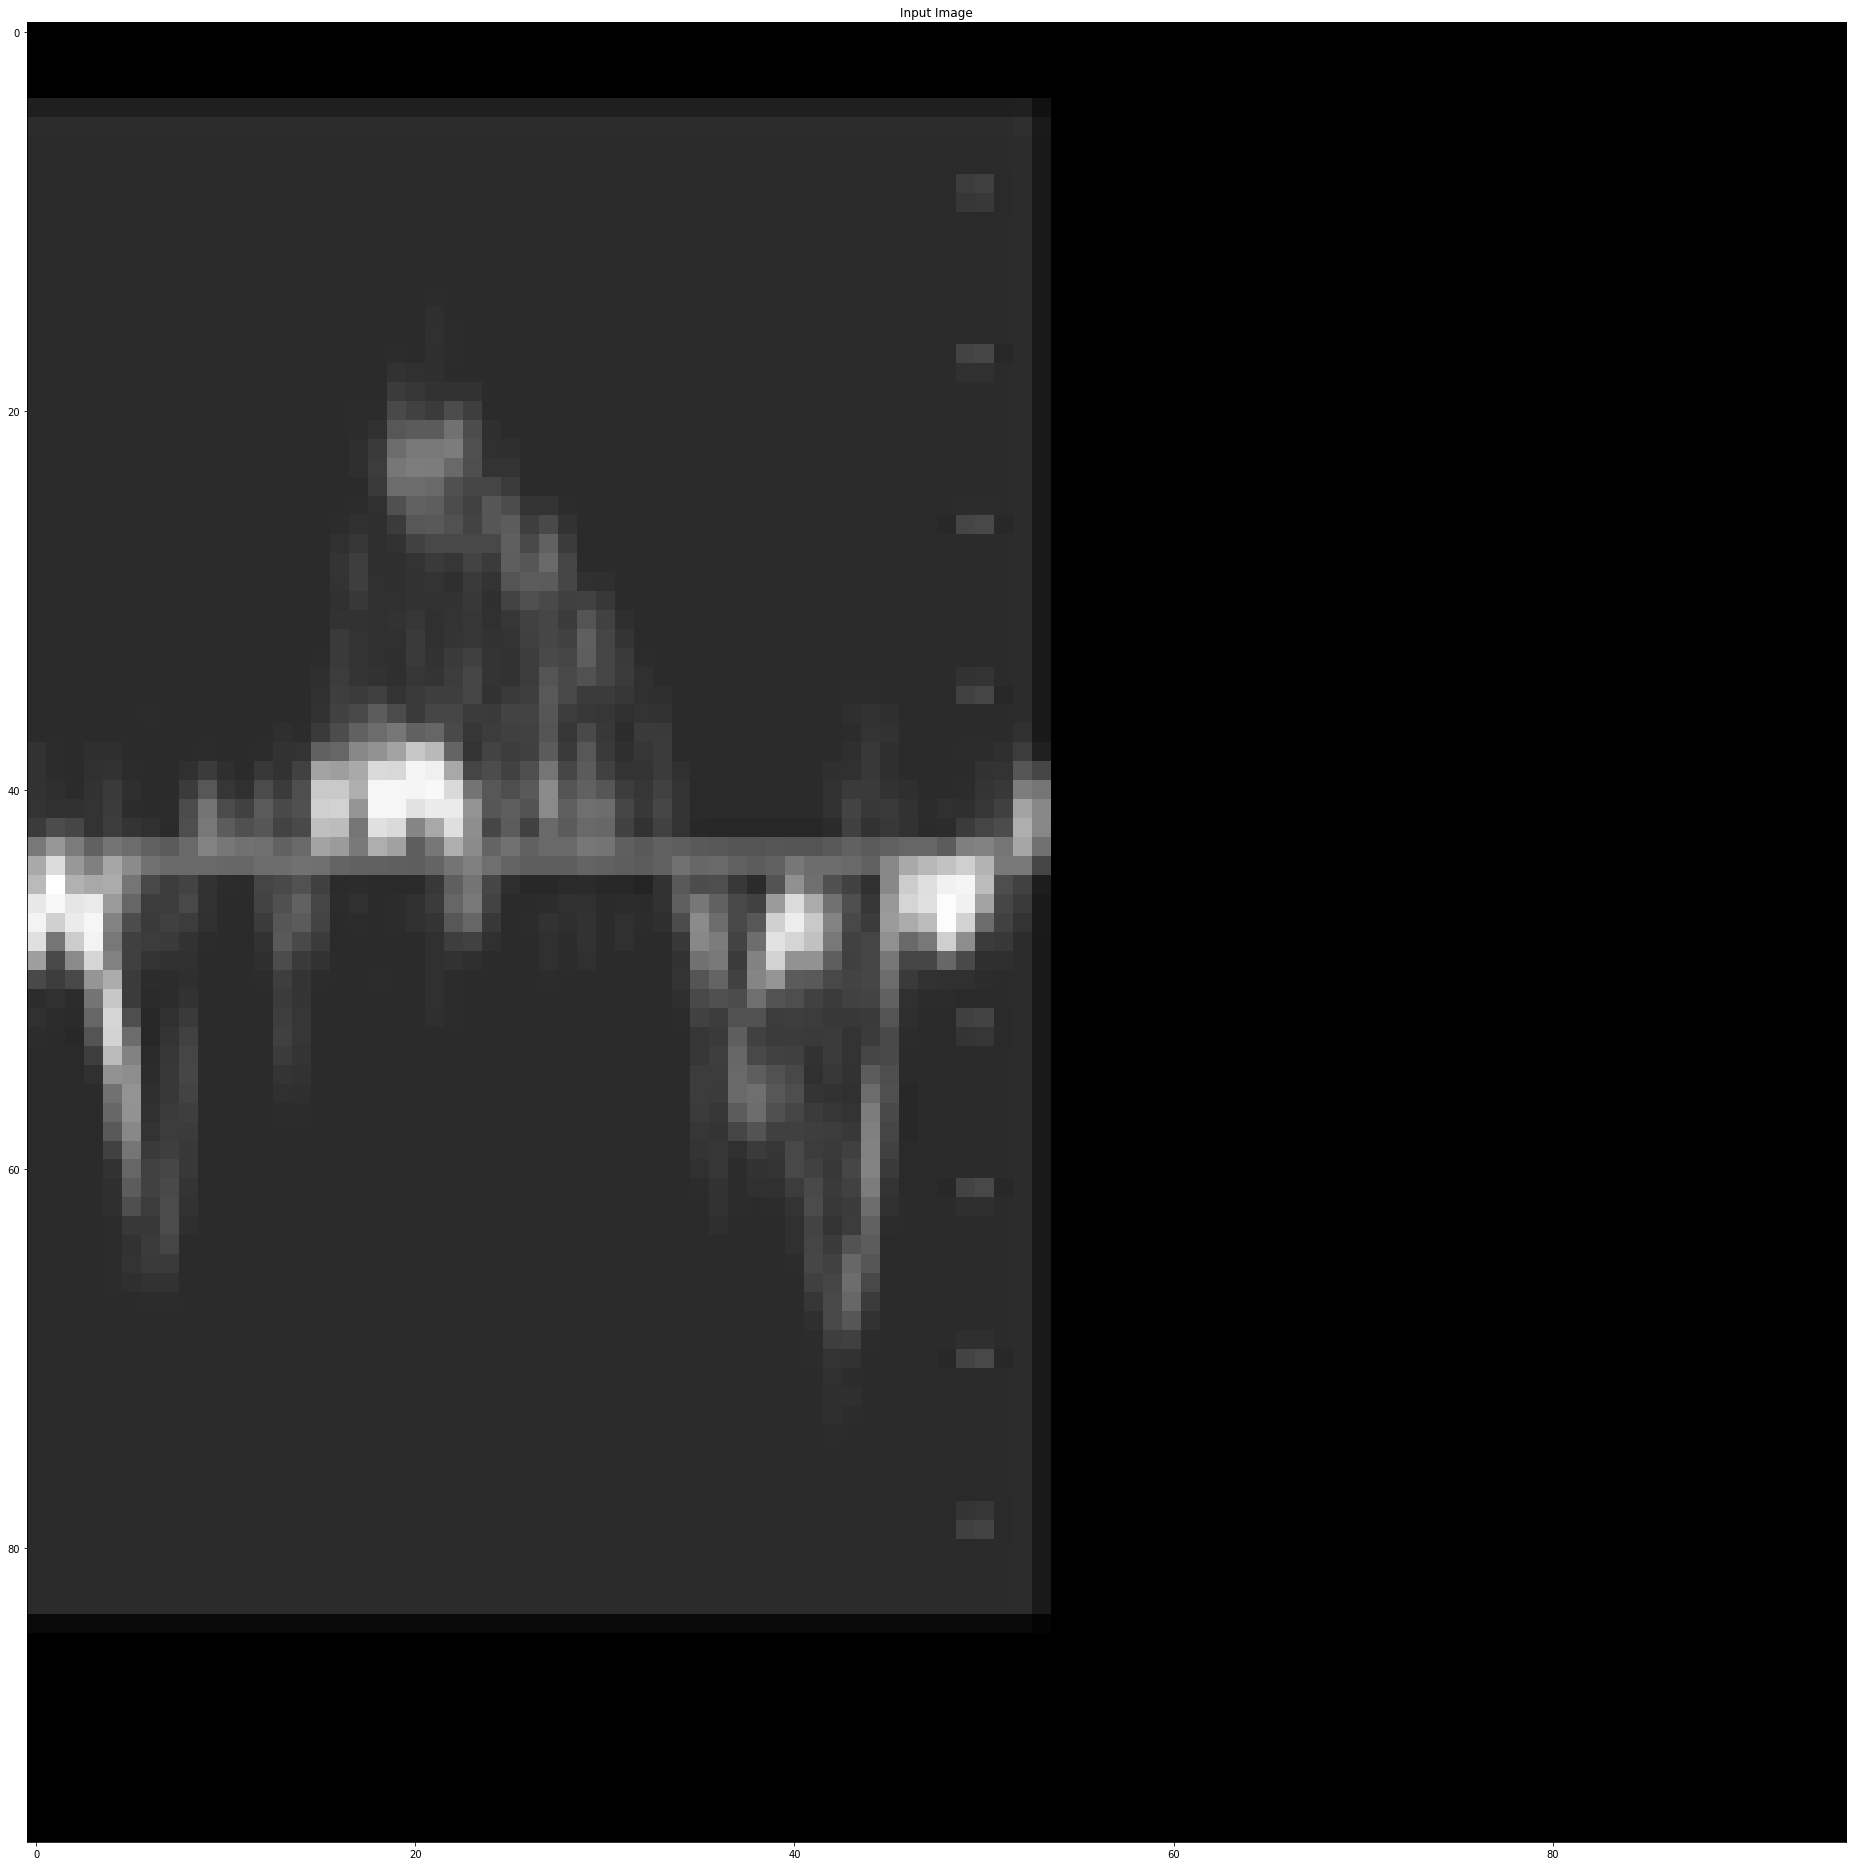

In [ ]:
plt.figure(figsize=(150,150))
plt.subplot(1,4,3)
plt.imshow(np.squeeze(X_train[0], axis=2), cmap='gray')
plt.title("Input Image")
plt.show

Each input image has 3 keypoints associated with it. Therefore each image is also going to have 3 heatmaps, one heatmap for each keypoint. As can been seen in the figures above, the areas of the heatmap that are more yellow represent pixels that are more likely for a keypoint location to be.

# Keras Custom Generator

Create a custom keras generator to yield batches of the heatmap data on-the-fly during training. Alternatively, one can create all the heatmaps before hand and then just pass them into a machine learning model, but the heatmaps take up a lot of memory and also there is no need to keep these heatmaps after training is finished.

Generators are a very important concept to learn for other machine learning problems, when your dataset is too big to fit into memory.

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

First, create a new Python class that inherits from keras.utilities.Sequence, which gives a nice functionality like multiprocessing.

To make a generator that inherits the keras.utilities.Sequence class, we need to create the following methods:

__init__(): this is your basic initialization method.
on_epoch_end(): this method is triggered every time your generator runs through one epoch of your data. Typically you would want to shuffle your dataset using this method.
__data_generation(): this is the method that actually does the data processing. In here you will create your batch of data.
__len__(): this method is used to tell the generator how many batches of data would be needed to complete one full epoch, it returns a number between 0 and the total number of batches. This number is passed into your other methods, typically called index.
__get_item__(): this method is the one that actually returns your batch of data.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, imgs, kps, batch_size=32, shuffle=True):
        self.imgs = imgs
        self.kps = kps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.imgs) // self.batch_size

    def __getitem__(self, index):
        #Get index of images to generate
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        #Shuffle the data after the generator has run through all samples
        self.indexes = np.arange(len(self.imgs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def gaussian(self, xL, yL, H, W, sigma=5):
        ##Function that creates the heatmaps##
        channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
        channel = np.array(channel, dtype=np.float32)
        channel = np.reshape(channel, newshape=(H, W))

        return channel

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        X_batch = [self.imgs[i] for i in indexes]
        X_batch = np.array(X_batch)
        
        y_batch = []
        
        kps = [self.kps[i] for i in indexes]
        
        for i in range(0,len(kps)):
            heatmaps = []
            for j in range(0, No_Of_Keypoints):
                x = int(kps[i][j*2])
                y = int(kps[i][j*2+1])
                heatmap = self.gaussian(x, y, im_w, im_h)
                heatmaps.append(heatmap)
            y_batch.append(heatmaps)
                
        y_batch = np.array(y_batch)
        y_batch = np.swapaxes(y_batch,1,3)
        y_batch = np.swapaxes(y_batch,1,2)
        return X_batch, [y_batch, y_batch]

(32, 96, 96, 1)
(32, 96, 96, 3)


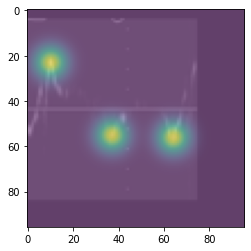

In [ ]:
#Testing to see if the DataGenerator is working
X_batch, [y_batch, _] = next(DataGenerator(X_train, y_train).__iter__())
print(X_batch.shape)
print(y_batch.shape)

#Plot a single image overlayed with its heatmaps
plt.imshow(X_batch[0].reshape(im_w, im_h), cmap='gray', alpha=0.5)
plt.imshow(y_batch[0].sum(axis=2), alpha=0.5)
plt.show()

DataGenerator actually yields two sets of y_batch, for a two-stage heatmap regression approach, with intermediate training:

https://arxiv.org/pdf/1602.00134.pdf

This concept is similar to traditional boosting algorithms in which the main idea is to learn from the mistakes of the first output. Basically, every stage is going to predict a heatmap and the next stage will use the previous stage's heatmap prediction along with the input image to create a new, more accurate prediction.

One thing we need to clarify is intermediate training. The more stages you make the model, the more layers it is going to have, hence your model might run into the Vanishing Gradient Problem. To combat this, we will be using intermediate training in which the total loss of the model is the summation of each individual stage's loss.

Here is a high level picture of how the multi-stage model works:

![alt text](https://i.imgur.com/xbtp8tC.png)

# Creating the Model

A traditional fully convolutional network with two stages and trained using intermediate training.

In [ ]:
#Helper function for building model
def conv_block(x, nconvs, n_filters, block_name, wd=None):
    for i in range(nconvs):
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   kernel_regularizer=wd, name=block_name + "_conv" + str(i + 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name=block_name + "_pool")(x)
    return x

In [ ]:
#Represents one stage of the model
def stages(x, stage_num, num_keypoints = 15):
  
    #Block 1
    x = conv_block(x, nconvs=2, n_filters=64, block_name="block1_stage{}".format(stage_num))
  
    #Block 2
    x = conv_block(x, nconvs=2, n_filters=128, block_name="block2_stage{}".format(stage_num))
  
    #Block 3
    pool3 = conv_block(x, nconvs=3, n_filters=256, block_name="block3_stage{}".format(stage_num))
  
    #Block 4
    pool4 = conv_block(pool3, nconvs=3, n_filters=512, block_name="block4_stage{}".format(stage_num))
    
  
    #Block 5
    x = conv_block(pool4, nconvs=3, n_filters=512, block_name="block5_stage{}".format(stage_num))
  
    #Convolution 6
    x = Conv2D(4096, kernel_size=(1, 1), strides=1, padding="same", activation="relu", name="conv6_stage{}".format(stage_num))(x)
  
    #Convolution 7
    x = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", activation="relu", name="conv7_stage{}".format(stage_num))(x)
   
    #upsampling
    preds_pool3 = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", name="preds_pool3_stage{}".format(stage_num))(pool3)
    
    preds_pool4 = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", name="preds_pool4_stage{}".format(stage_num))(pool4)
    
    up_pool4 = Conv2DTranspose(filters=15, kernel_size=2, strides=2, activation='relu', name="ConvT_pool4_stage{}".format(stage_num))(preds_pool4)
    
    up_conv7 = Conv2DTranspose(filters=15, kernel_size=4, strides=4, activation='relu', name="ConvT_conv7_stage{}".format(stage_num))(x)
      
    fusion = Add()([preds_pool3, up_pool4, up_conv7])
  
    heatmaps = Conv2DTranspose(filters=15, kernel_size=8, strides=8, activation='relu', name="convT_fusion_stage{}".format(stage_num))(fusion)
    heatmaps = Conv2D(num_keypoints, kernel_size=(1, 1), strides=1, padding="same", activation="linear", name="output_stage{}".format(stage_num))(heatmaps)

    return heatmaps

In [ ]:
#Create a single stage FCN
def build_model(input_shape, No_Of_Keypoints):
    outputs = []
  
    img = Input(shape=input_shape, name="Input_stage")
  
    ### Stage 1 ###
    heatmaps1 = stages(img, 1, No_Of_Keypoints)
    outputs.append(heatmaps1)
  
    ### Stage 2 ###
    x = Concatenate()([img, heatmaps1])
    heatmaps2 = stages(x, 2, No_Of_Keypoints) 
    outputs.append(heatmaps2)
  
    model = Model(inputs=img, outputs=outputs, name="FCN_Final")
    return model

In [ ]:
#Training the model using mean squared losss
def get_loss_func():
    def mse(x, y):
        return mean_squared_error(x,y)
  
    keys = ['output_stage1', 'output_stage2']
    losses = dict.fromkeys(keys, mse)
    return losses

model = build_model((im_w, im_h,1), No_Of_Keypoints)
losses = get_loss_func()
model.compile(loss =losses , optimizer ='adam',metrics=['accuracy'])
model.summary()

Model: "FCN_Final"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_stage (InputLayer)        [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
block1_stage1_conv1 (Conv2D)    (None, 96, 96, 64)   640         Input_stage[0][0]                
__________________________________________________________________________________________________
block1_stage1_conv2 (Conv2D)    (None, 96, 96, 64)   36928       block1_stage1_conv1[0][0]        
__________________________________________________________________________________________________
block1_stage1_pool (MaxPooling2 (None, 48, 48, 64)   0           block1_stage1_conv2[0][0]        
__________________________________________________________________________________________

# Training the Model

In [ ]:
#First, lets split the data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

#Create your two generators for train and validation
gen_train = DataGenerator(X_train, y_train)
gen_val = DataGenerator(X_val, y_val)

#Train the model
hist = model.fit(gen_train, epochs = 10, validation_data = gen_val)

Epoch 1/10
93/93 [==============================] - 116s 1s/step - loss: 0.0194 - output_stage1_loss: 0.0112 - output_stage2_loss: 0.0082 - output_stage1_accuracy: 0.3185 - output_stage2_accuracy: 0.3872 - val_loss: 0.0085 - val_output_stage1_loss: 0.0051 - val_output_stage2_loss: 0.0034 - val_output_stage1_accuracy: 0.3689 - val_output_stage2_accuracy: 0.5792
Epoch 2/10
93/93 [==============================] - 107s 1s/step - loss: 0.0066 - output_stage1_loss: 0.0042 - output_stage2_loss: 0.0024 - output_stage1_accuracy: 0.3614 - output_stage2_accuracy: 0.5926 - val_loss: 0.0029 - val_output_stage1_loss: 0.0019 - val_output_stage2_loss: 0.0011 - val_output_stage1_accuracy: 0.3762 - val_output_stage2_accuracy: 0.5851
Epoch 3/10
93/93 [==============================] - 103s 1s/step - loss: 0.0025 - output_stage1_loss: 0.0016 - output_stage2_loss: 9.5499e-04 - output_stage1_accuracy: 0.3752 - output_stage2_accuracy: 0.5856 - val_loss: 0.0018 - val_output_stage1_loss: 0.0011 - val_output_s

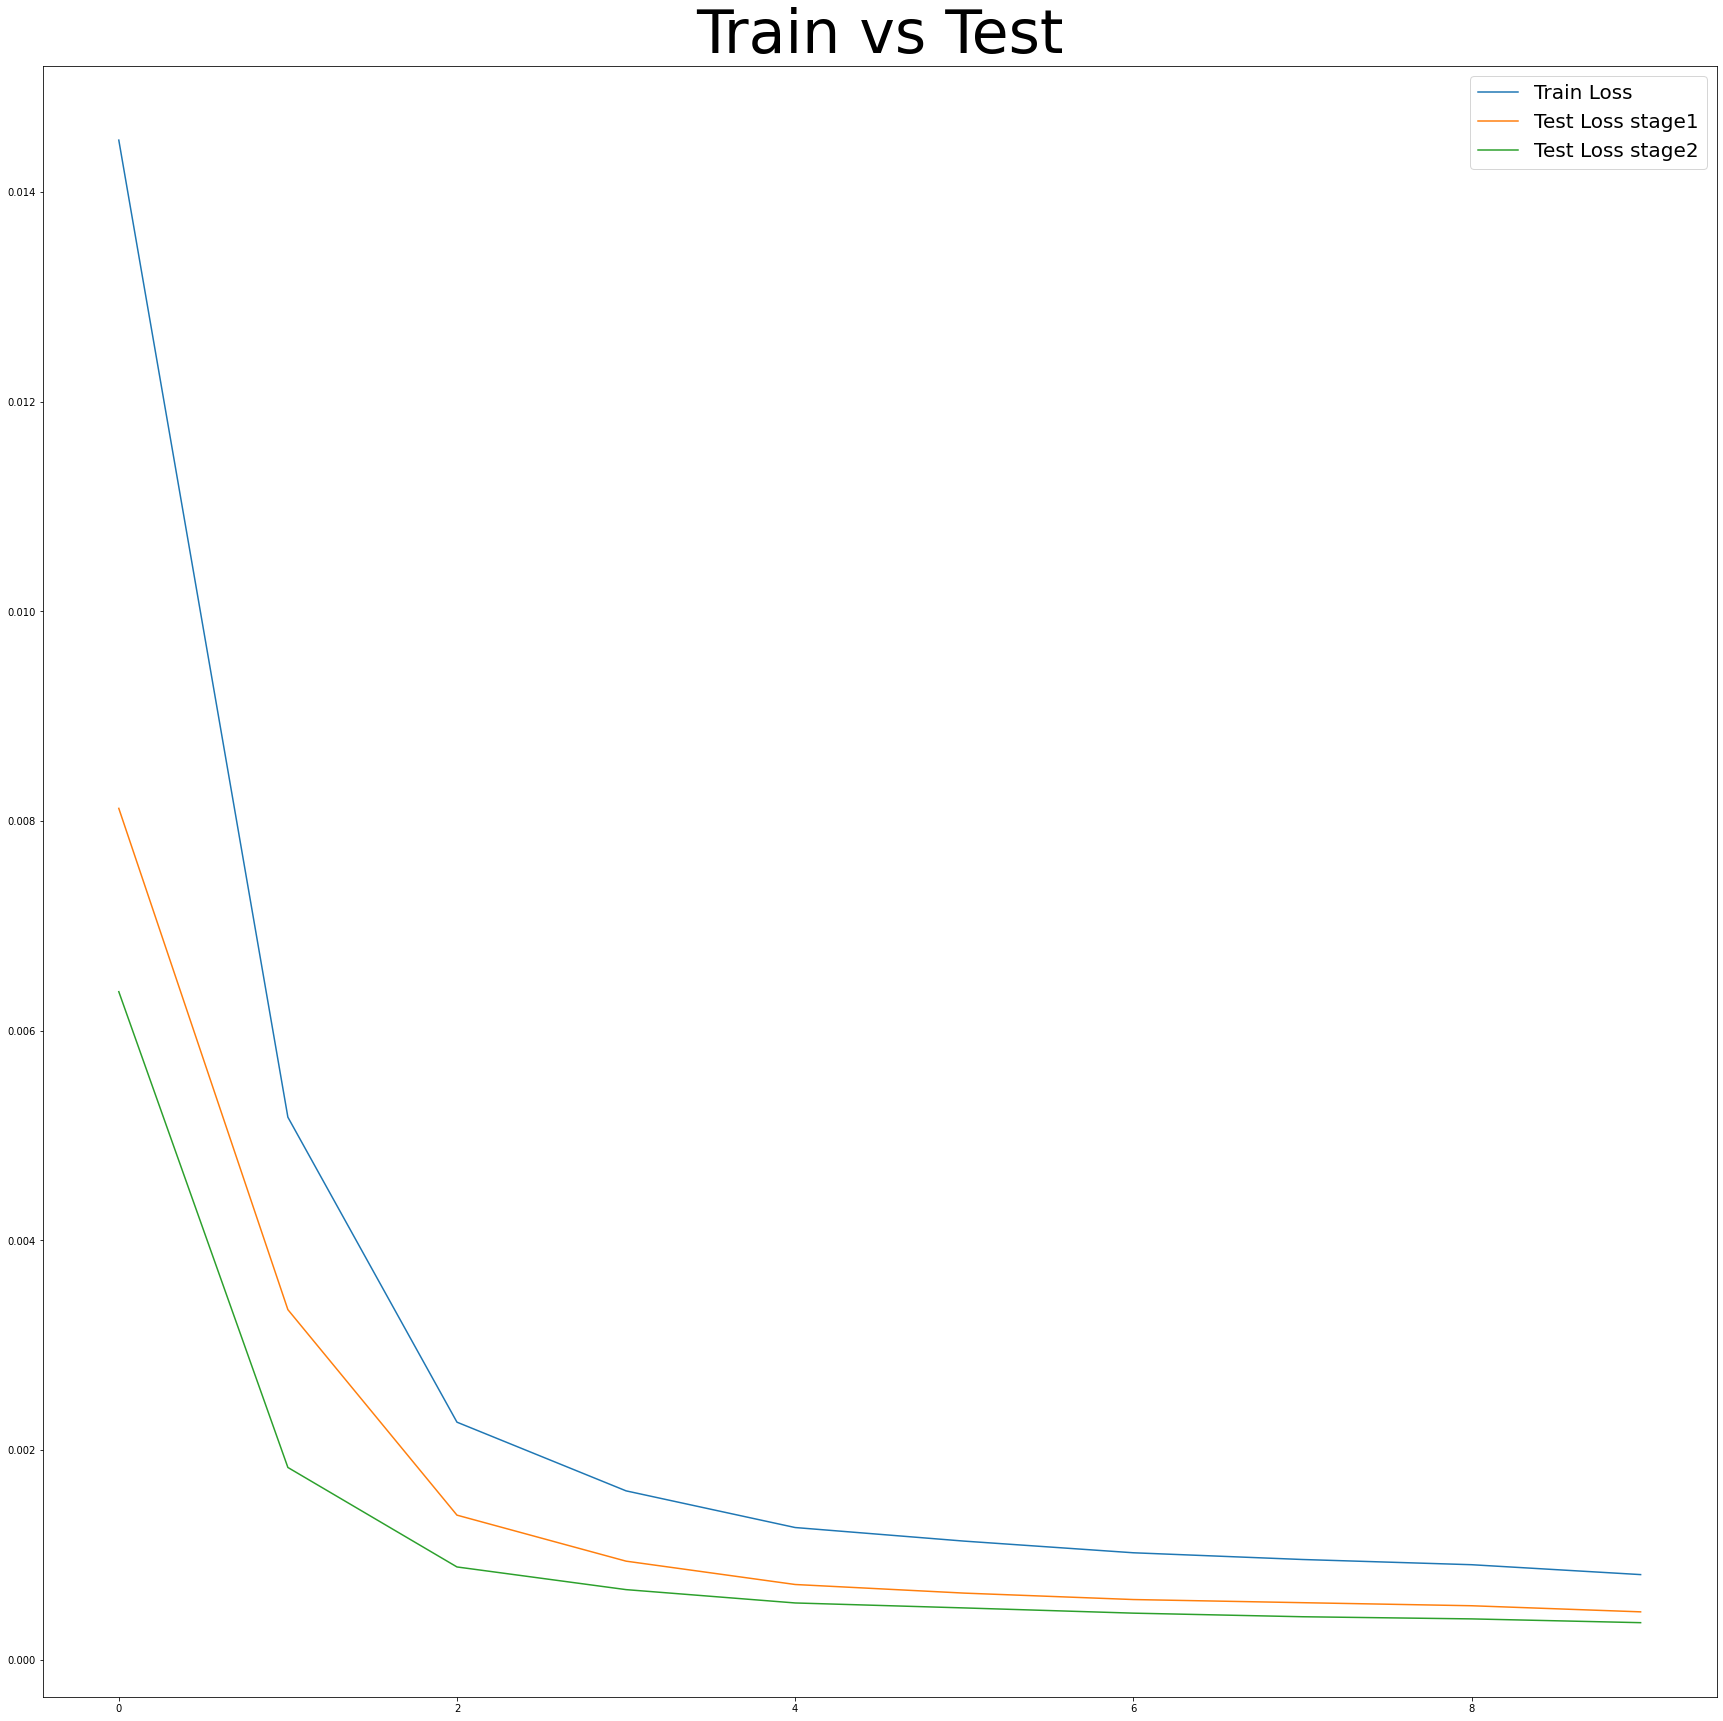

In [ ]:
plt.figure(figsize=(30,30))
Fontsize = 60
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['output_stage1_loss'], label='Test Loss stage1')
plt.plot(hist.history['output_stage2_loss'], label='Test Loss stage2',)
plt.legend(fontsize=20)
plt.title("Train vs Test",fontsize=Fontsize)
plt.savefig('/content/gdrive/MyDrive/keypoint/TrainStage1VsTrainStage2.jpg')
plt.show()

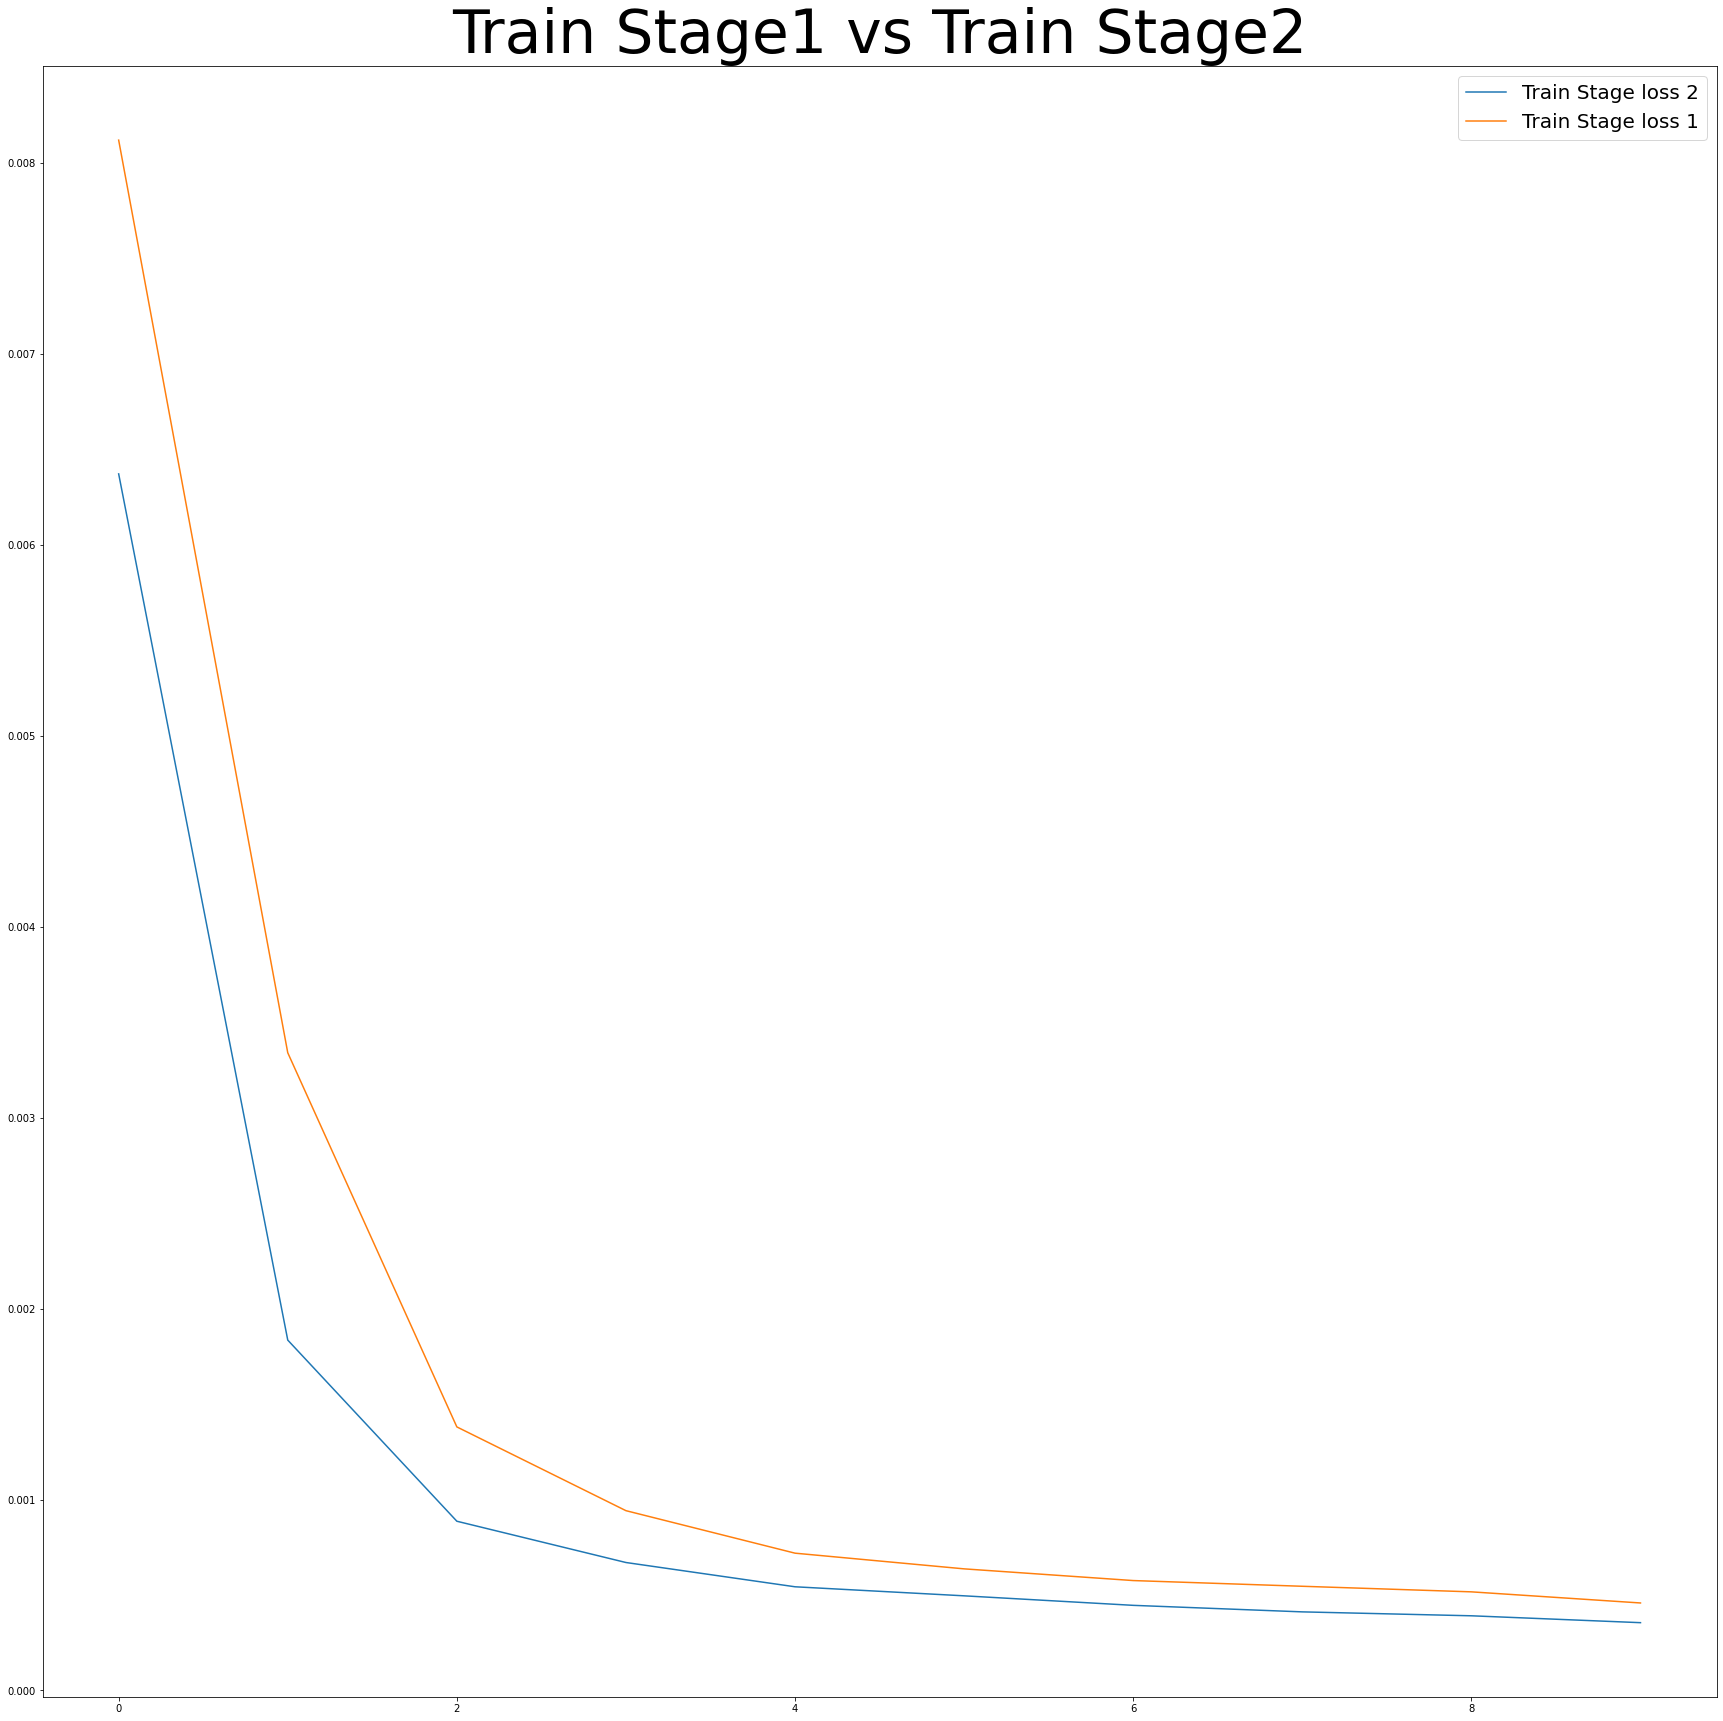

In [ ]:
plt.figure(figsize=(30,30))
Fontsize = 60
plt.plot(hist.history['output_stage2_loss'], label='Train Stage loss 2')
plt.plot(hist.history['output_stage1_loss'], label='Train Stage loss 1')
plt.title("Train Stage1 vs Train Stage2",fontsize=Fontsize)
plt.legend(fontsize=20)
plt.savefig('/content/gdrive/MyDrive/keypoint/stage1VsStage2.jpg')
plt.show()


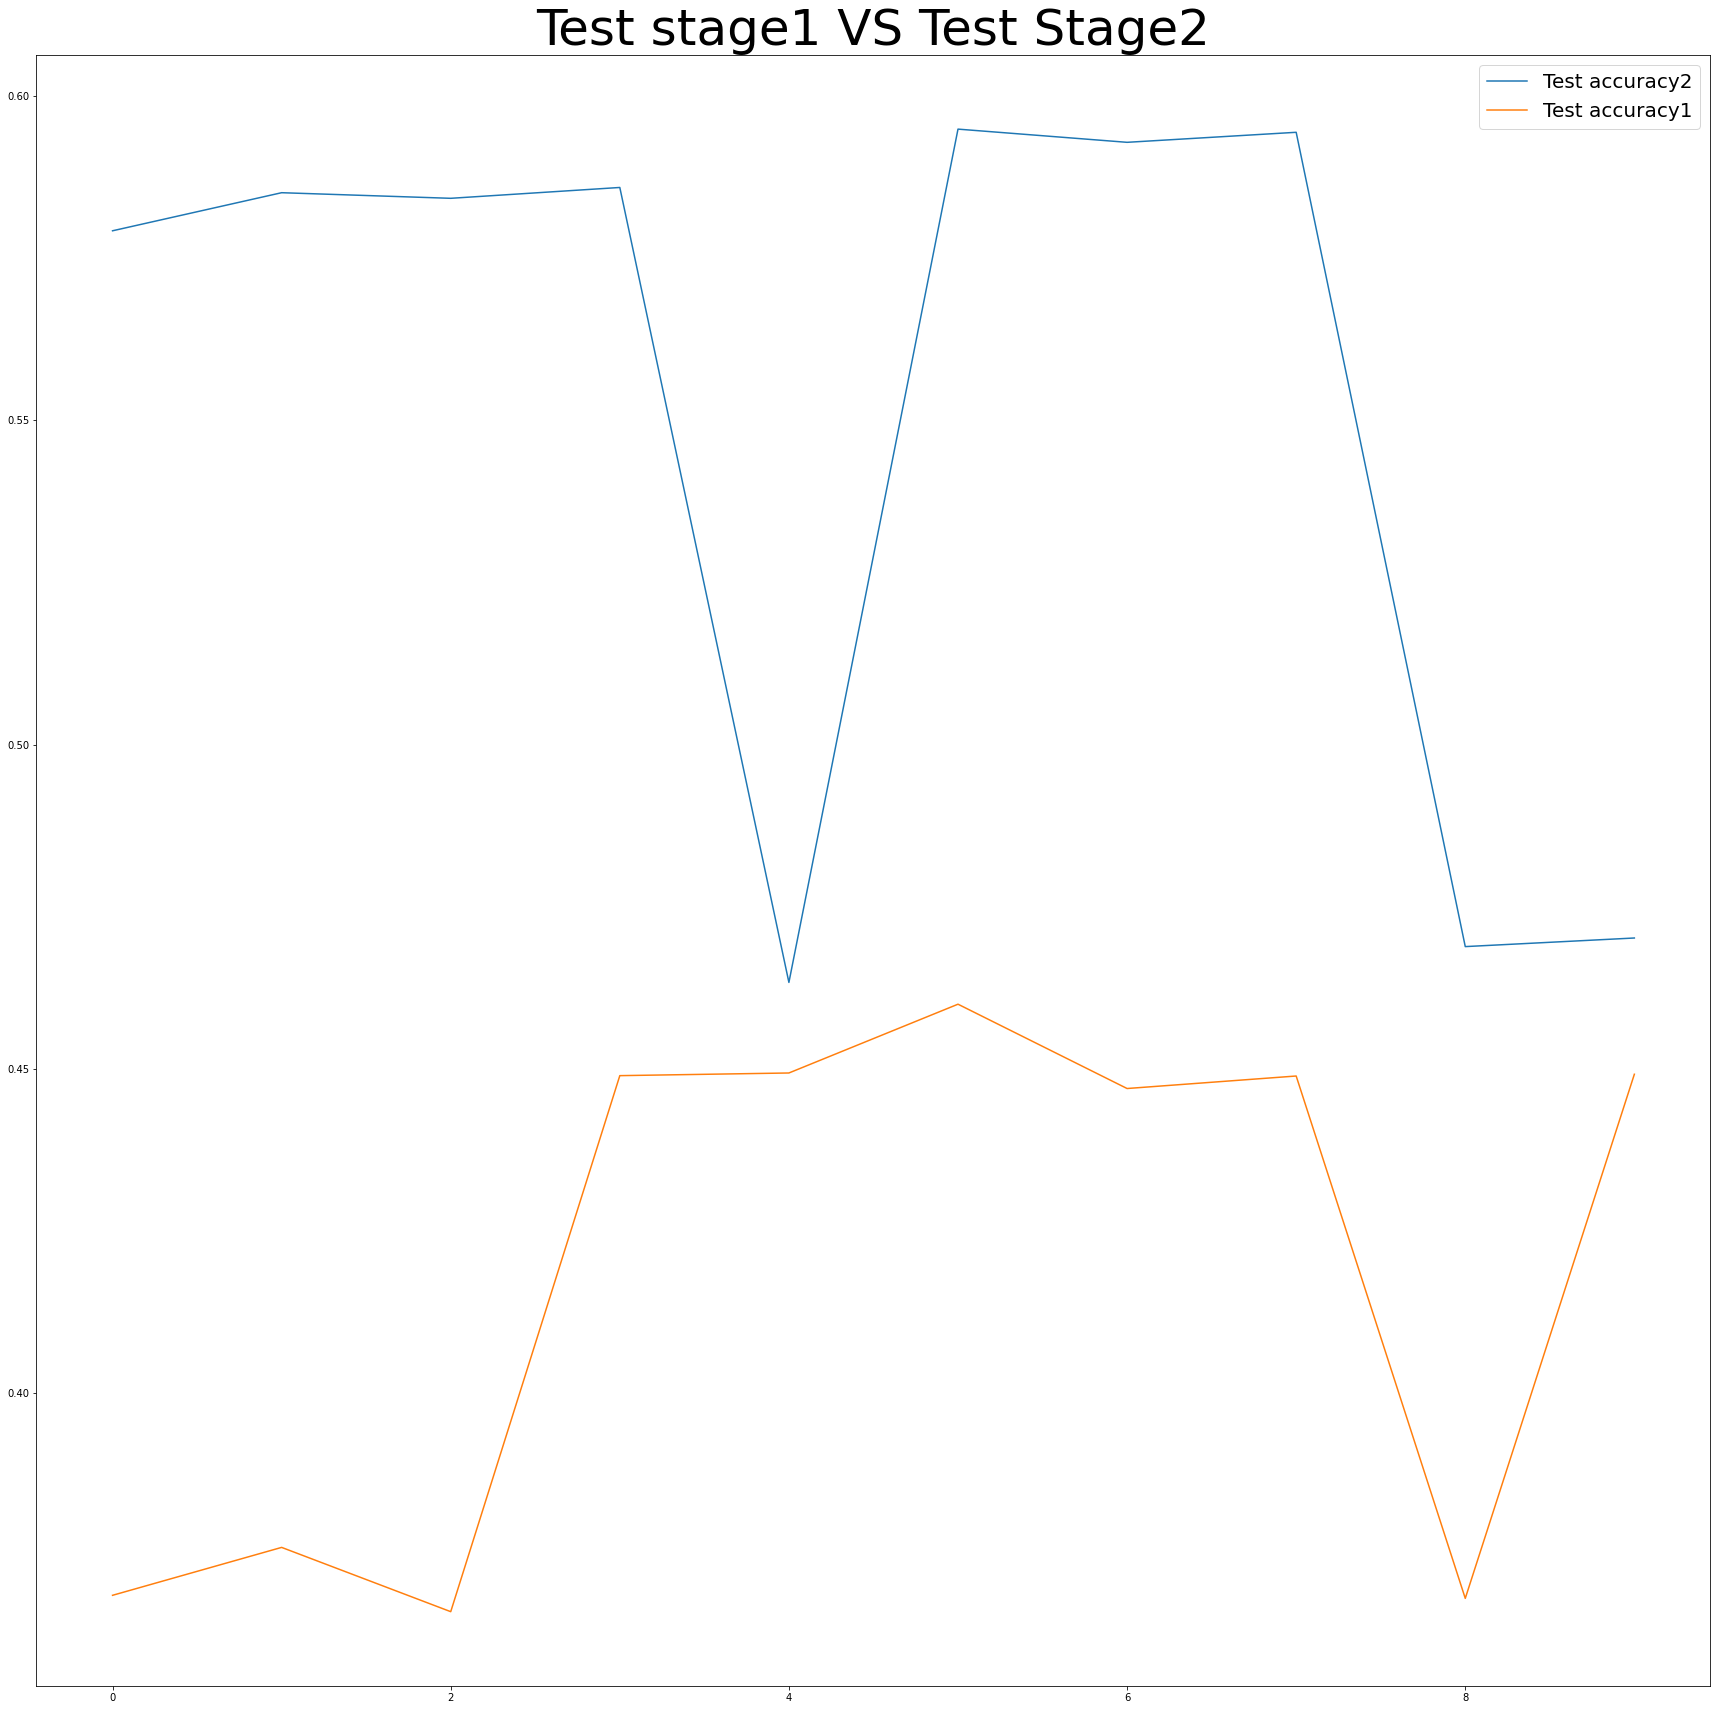

In [ ]:
plt.figure(figsize=(30,30))
plt.plot(hist.history['val_output_stage2_accuracy'], label='Test accuracy2')
plt.plot(hist.history['val_output_stage1_accuracy'], label='Test accuracy1')
plt.title("Test stage1 VS Test Stage2",fontsize=50)
plt.legend(fontsize=20)
plt.savefig('/content/gdrive/MyDrive/keypoint/TestStage1VsTestStage2')
plt.show()

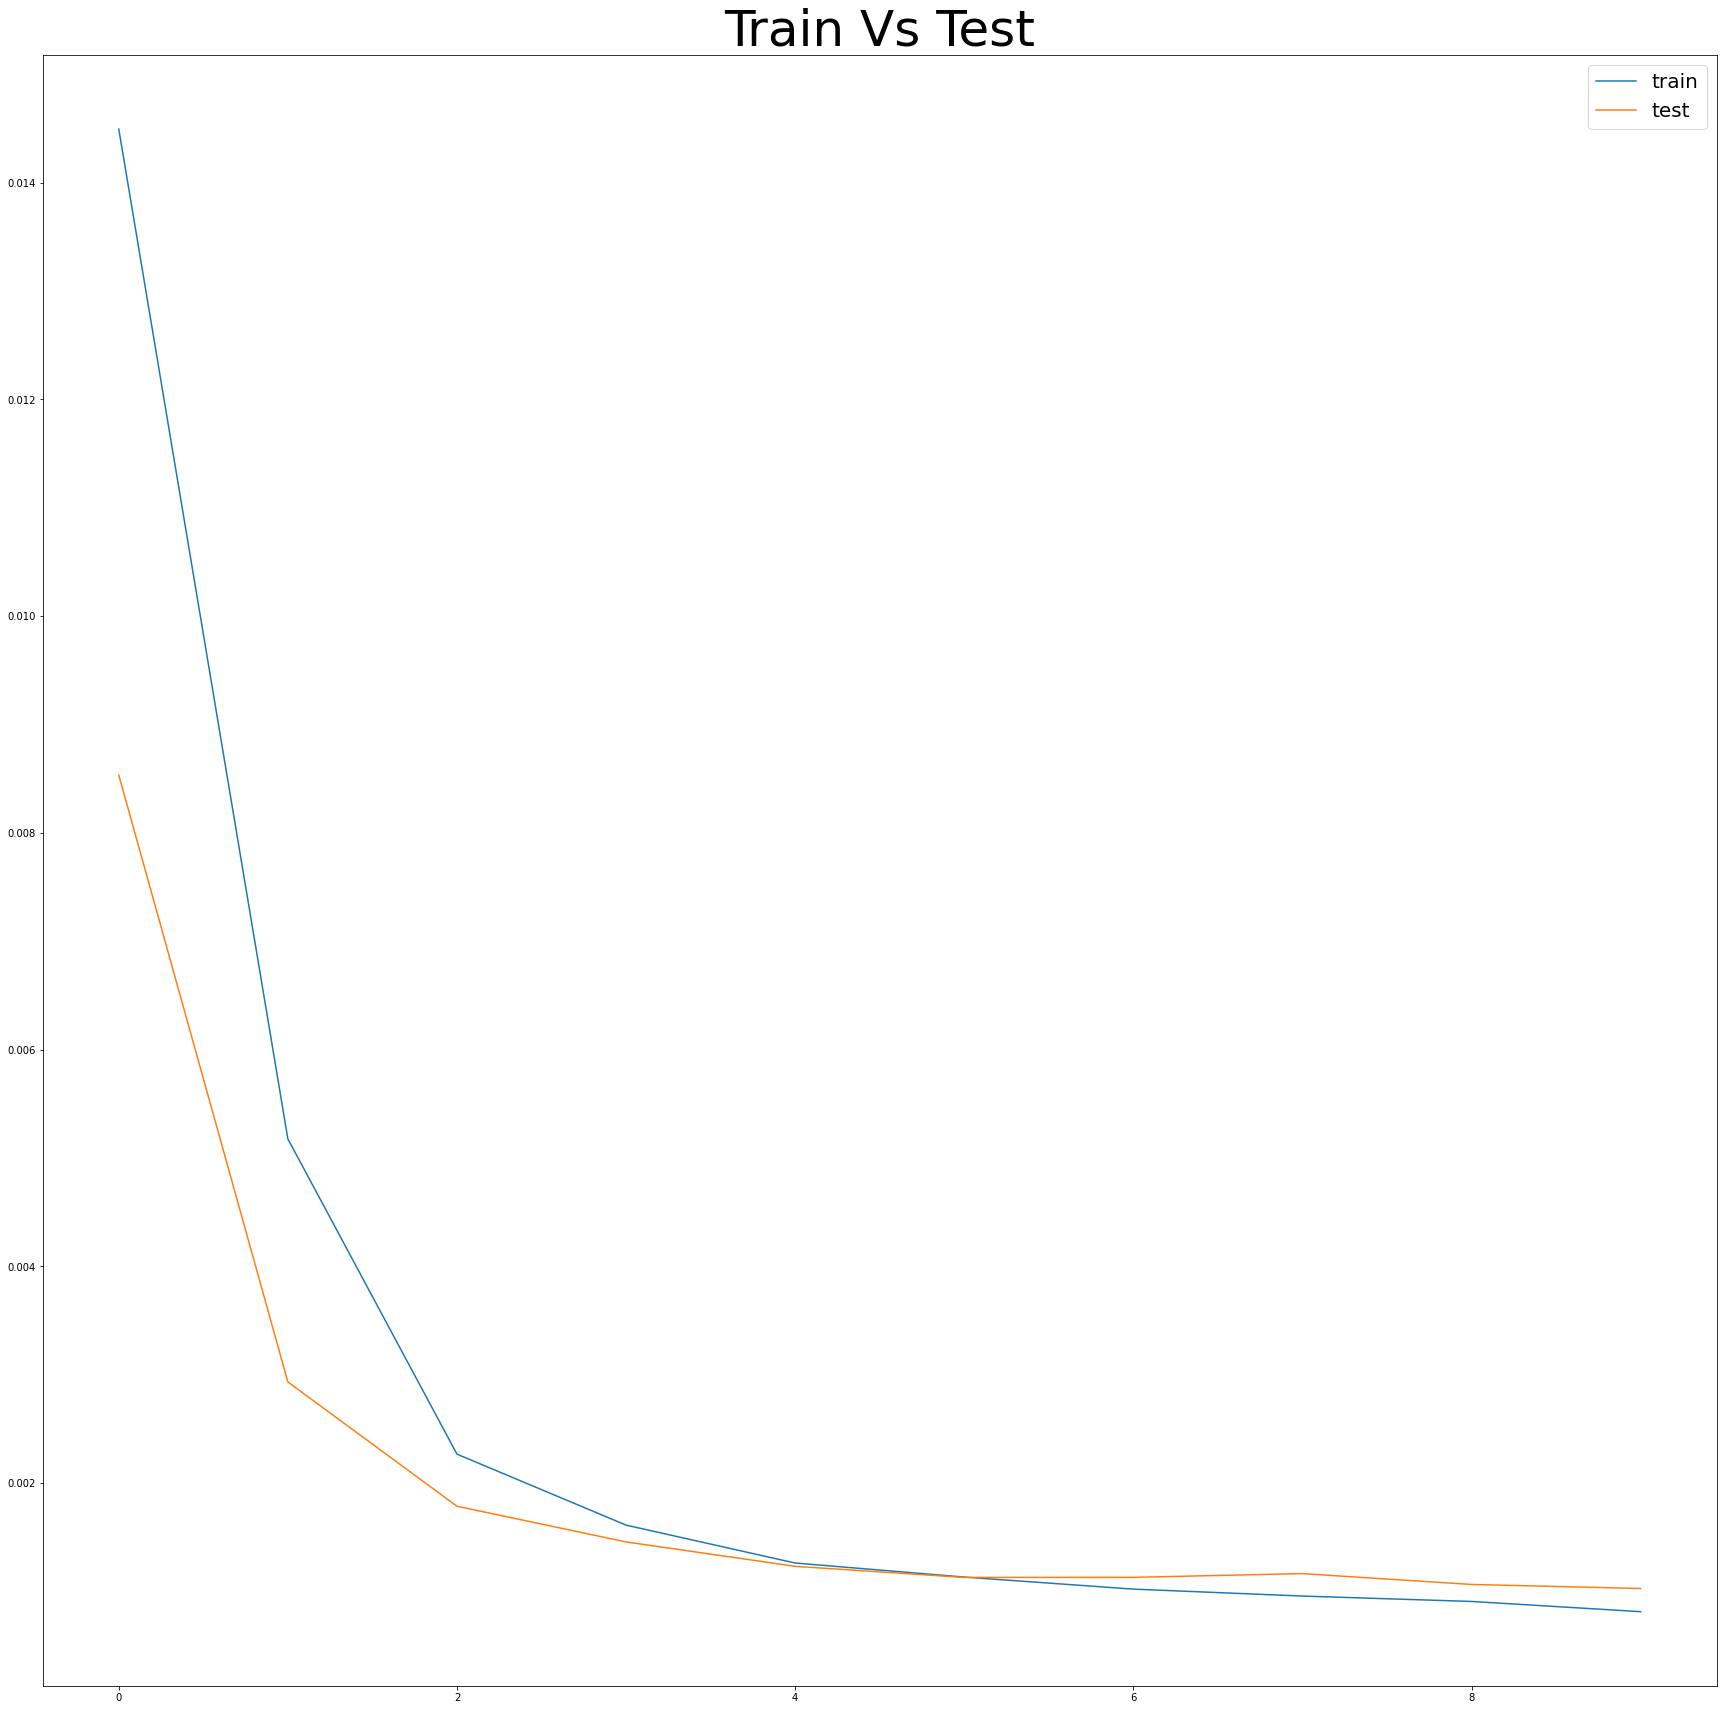

In [ ]:
plt.figure(figsize=(30,30))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.title("Train Vs Test",fontsize=50)
plt.legend(fontsize=20)
plt.savefig('/content/gdrive/MyDrive/keypoint/TrainVsTest.jpg')
plt.show()

In [ ]:
model_path = '/content/gdrive/My Drive/Colab Notebooks/Keypoint/saved_model.hdf5'
model.save(model_path)
#model = keras.models.load_model(model_path)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
X_batch, [y_batch, _] = next(gen_val.__iter__())

# index = np.random.randint(0,32)
index=1

predictions = model.predict(X_batch)
#confusion_matrix(np.array(predictions),y_batch)
print(y_batch.shape)
p=np.array(predictions)
#print(p.reshape(32,96,96,3))

(32, 96, 96, 3)


ValueError: ignored

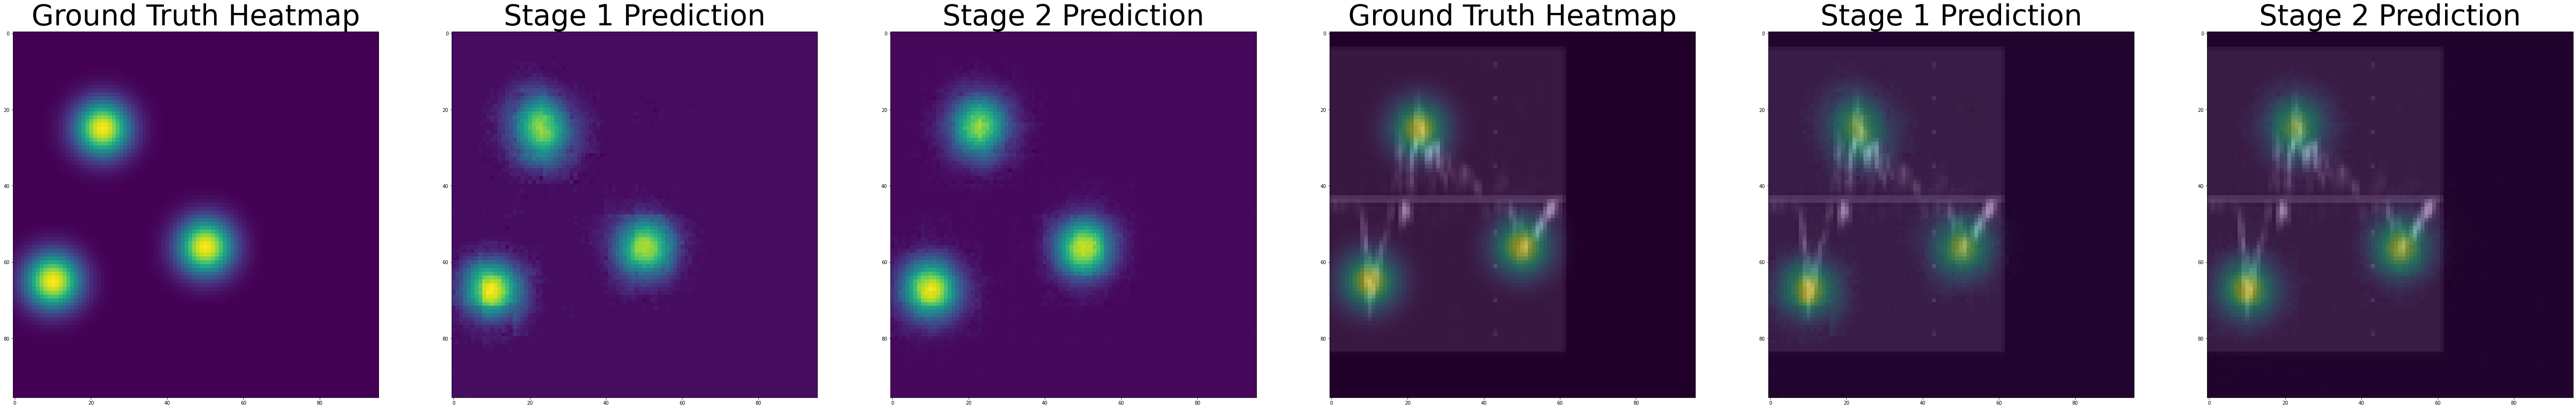

In [ ]:
X_batch, [y_batch, _] = next(gen_val.__iter__())

# index = np.random.randint(0,32)
index=1

predictions = model.predict(X_batch)

Fontsize = 60

plt.figure(figsize=(96,96))
plt.subplot(1,6,1)
plt.imshow(y_batch[index].sum(axis=2))
plt.title("Ground Truth Heatmap", fontsize=Fontsize)


plt.subplot(1,6,2)
plt.imshow(predictions[0][index].sum(axis=2))
plt.title("Stage 1 Prediction", fontsize=Fontsize)


plt.subplot(1,6,3)
plt.imshow(predictions[1][index].sum(axis=2))
plt.title("Stage 2 Prediction", fontsize=Fontsize)


#Plot an image overlayed with its heatmaps
plt.subplot(1,6,4)
plt.imshow(X_batch[index].reshape(im_w, im_h), cmap='gray')
plt.imshow(y_batch[index].sum(axis=2), alpha=0.5)
plt.title("Ground Truth Heatmap", fontsize=Fontsize)

plt.subplot(1,6,5)
plt.imshow(X_batch[index].reshape(im_w, im_h), cmap='gray')
plt.imshow(predictions[0][index].sum(axis=2), alpha=0.5)
plt.title("Stage 1 Prediction", fontsize=Fontsize)

plt.subplot(1,6,6)
plt.imshow(X_batch[index].reshape(im_w, im_h), cmap='gray')
plt.imshow(predictions[1][index].sum(axis=2), alpha=0.5)
plt.title("Stage 2 Prediction", fontsize=Fontsize)

plt.show()

In [ ]:
%cd /content/gdrive/MyDrive/keypoint 

/content/gdrive/MyDrive/keypoint


No: 1


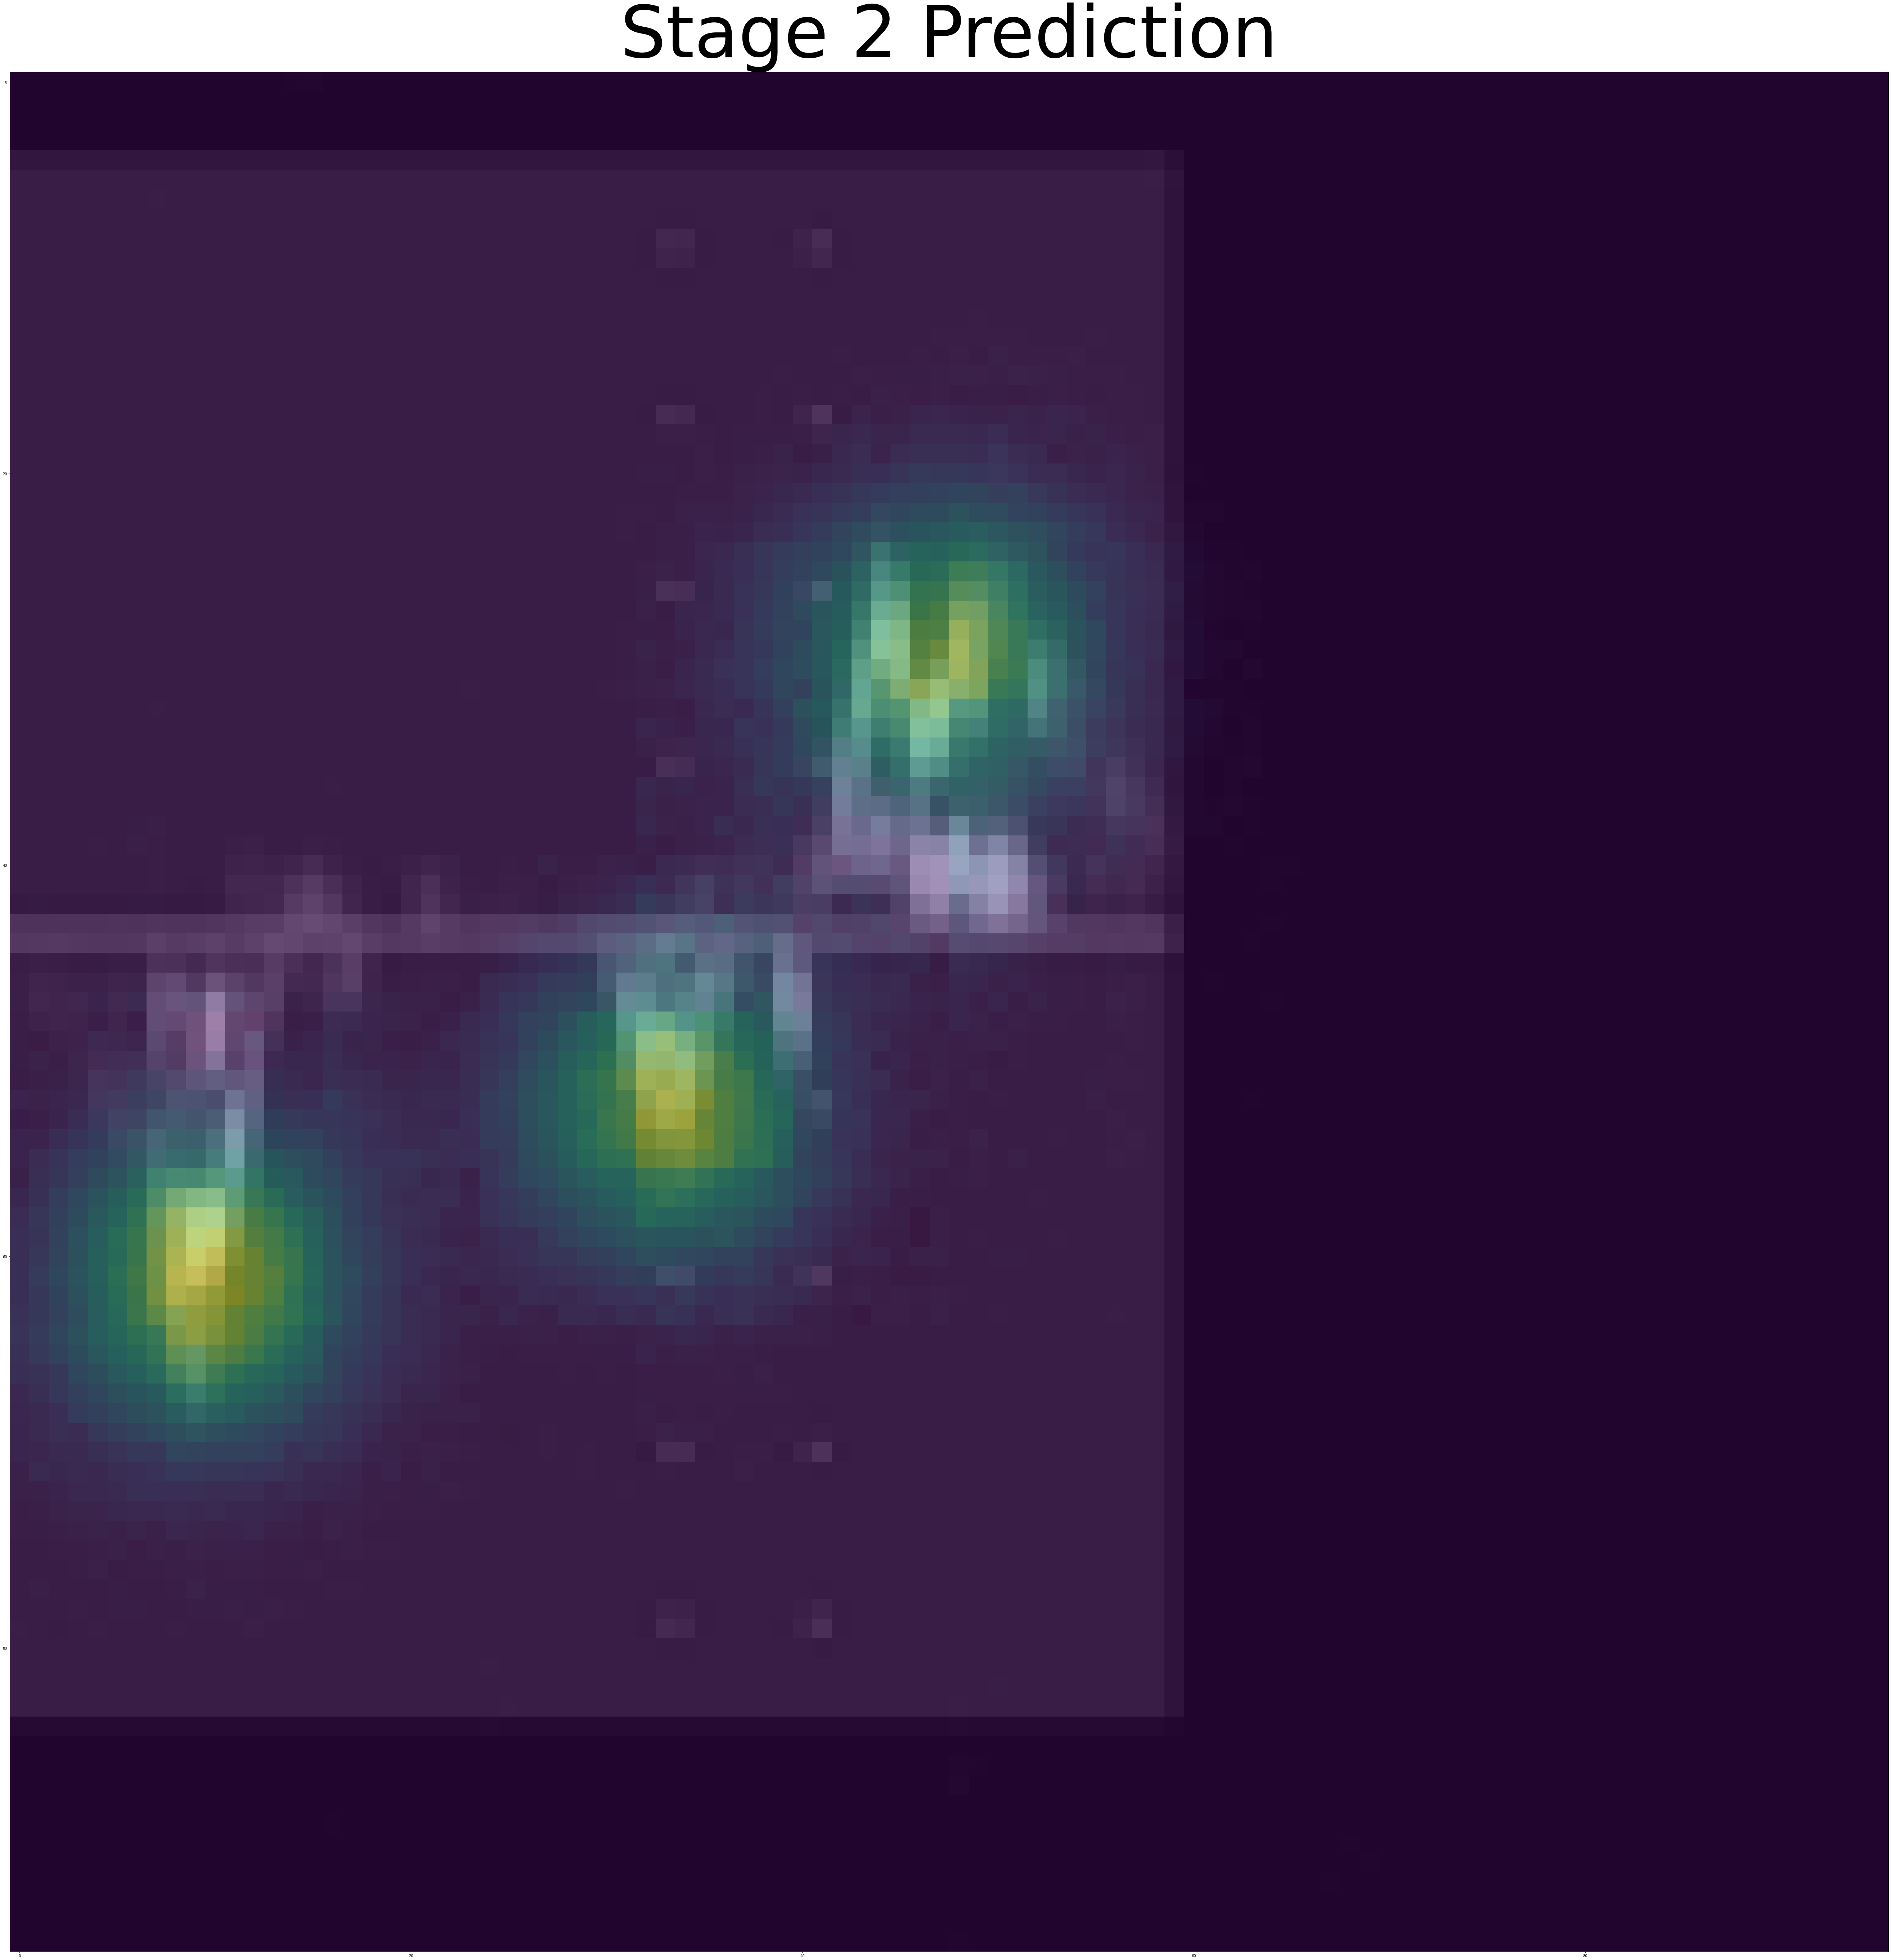

No: 2


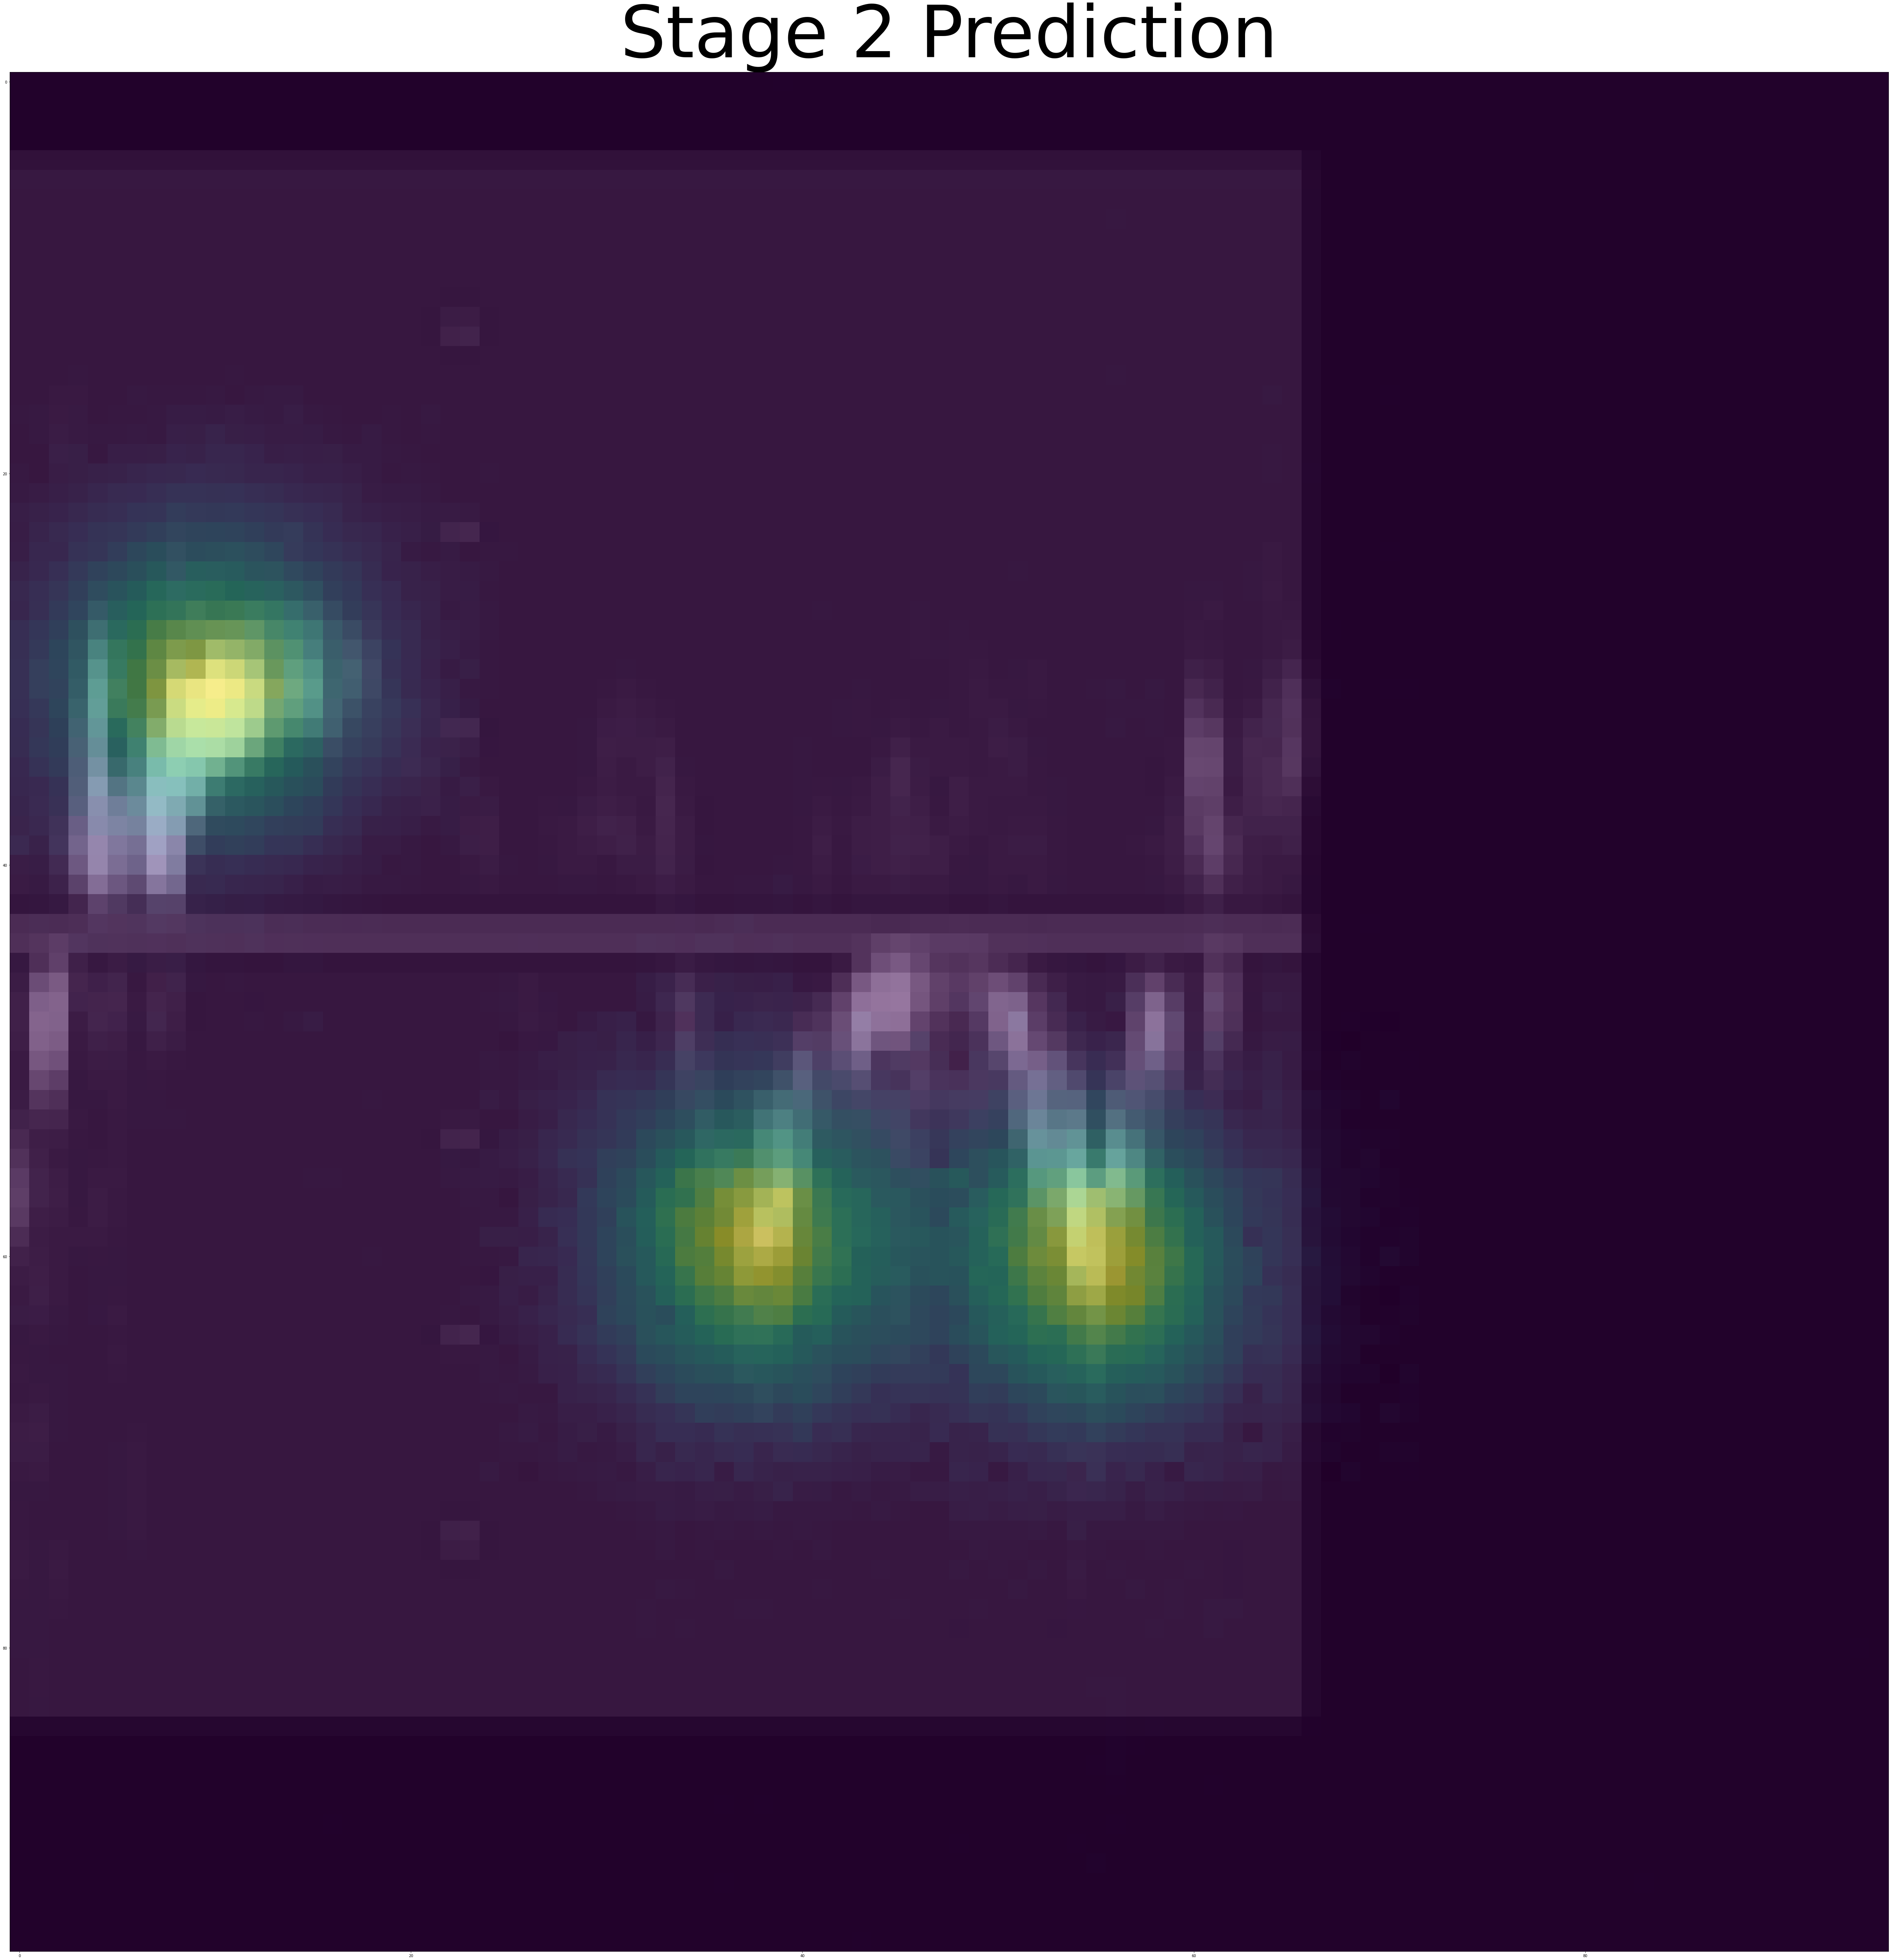

No: 3


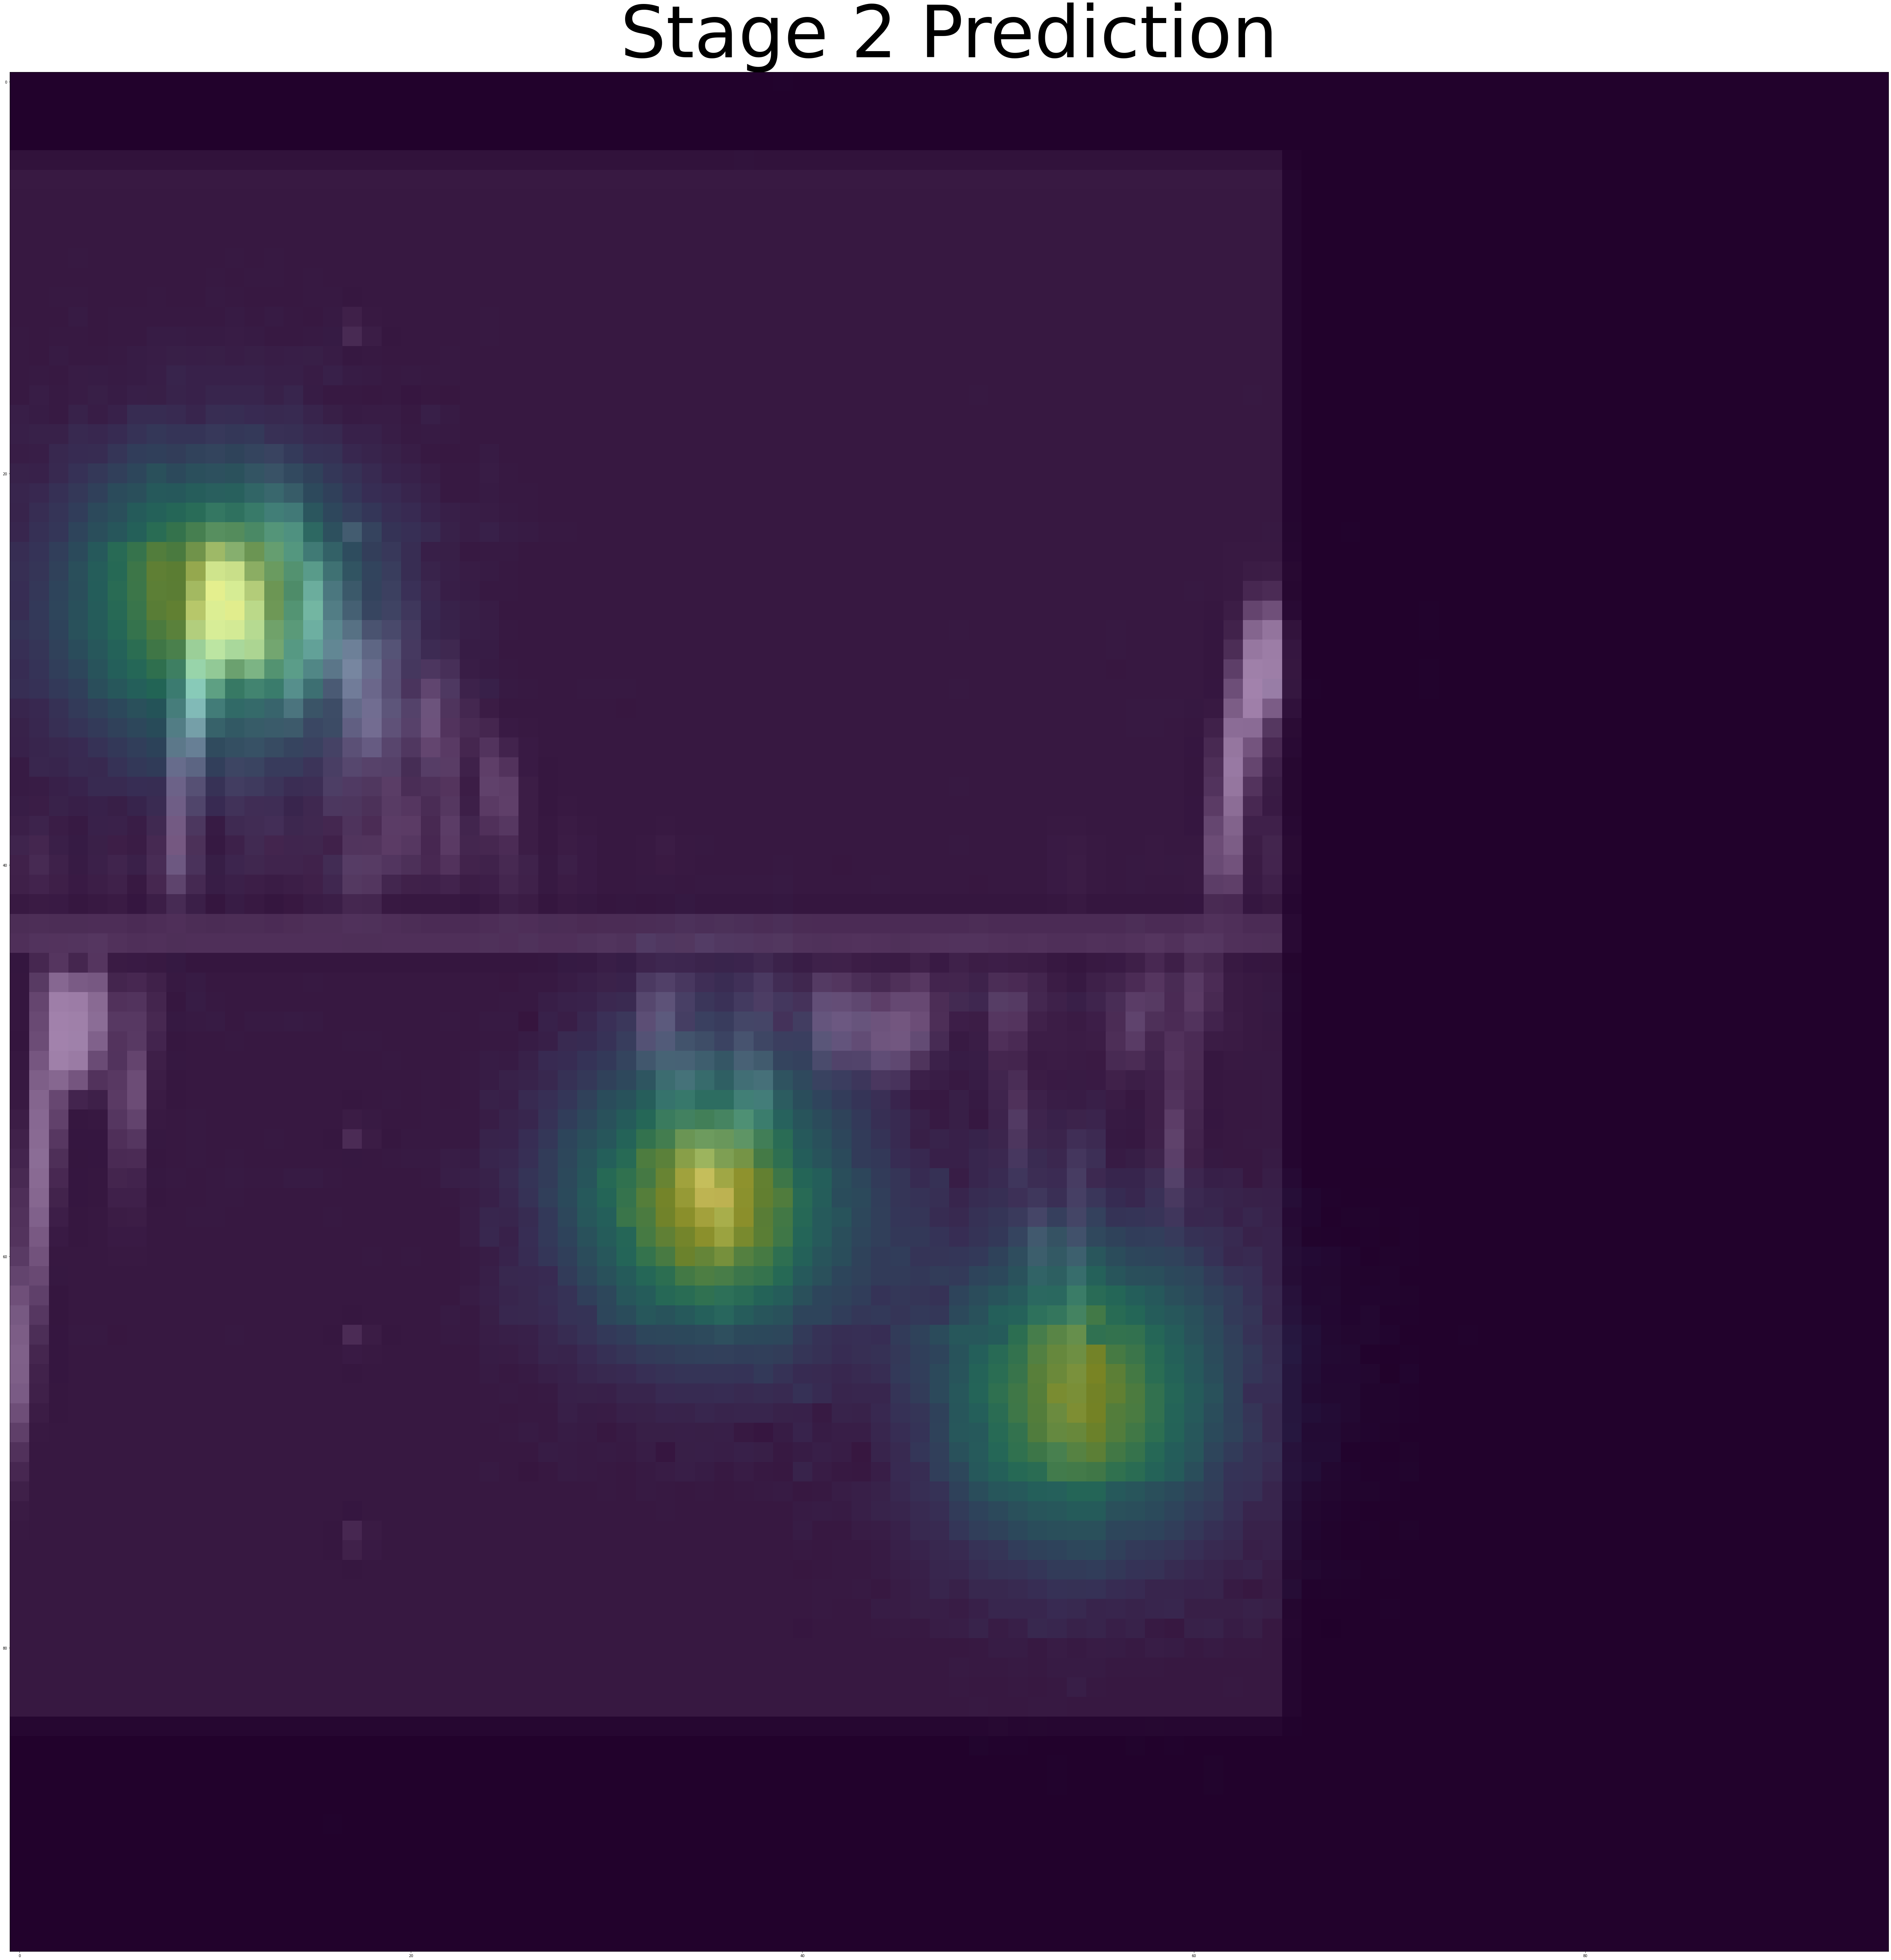

No: 4


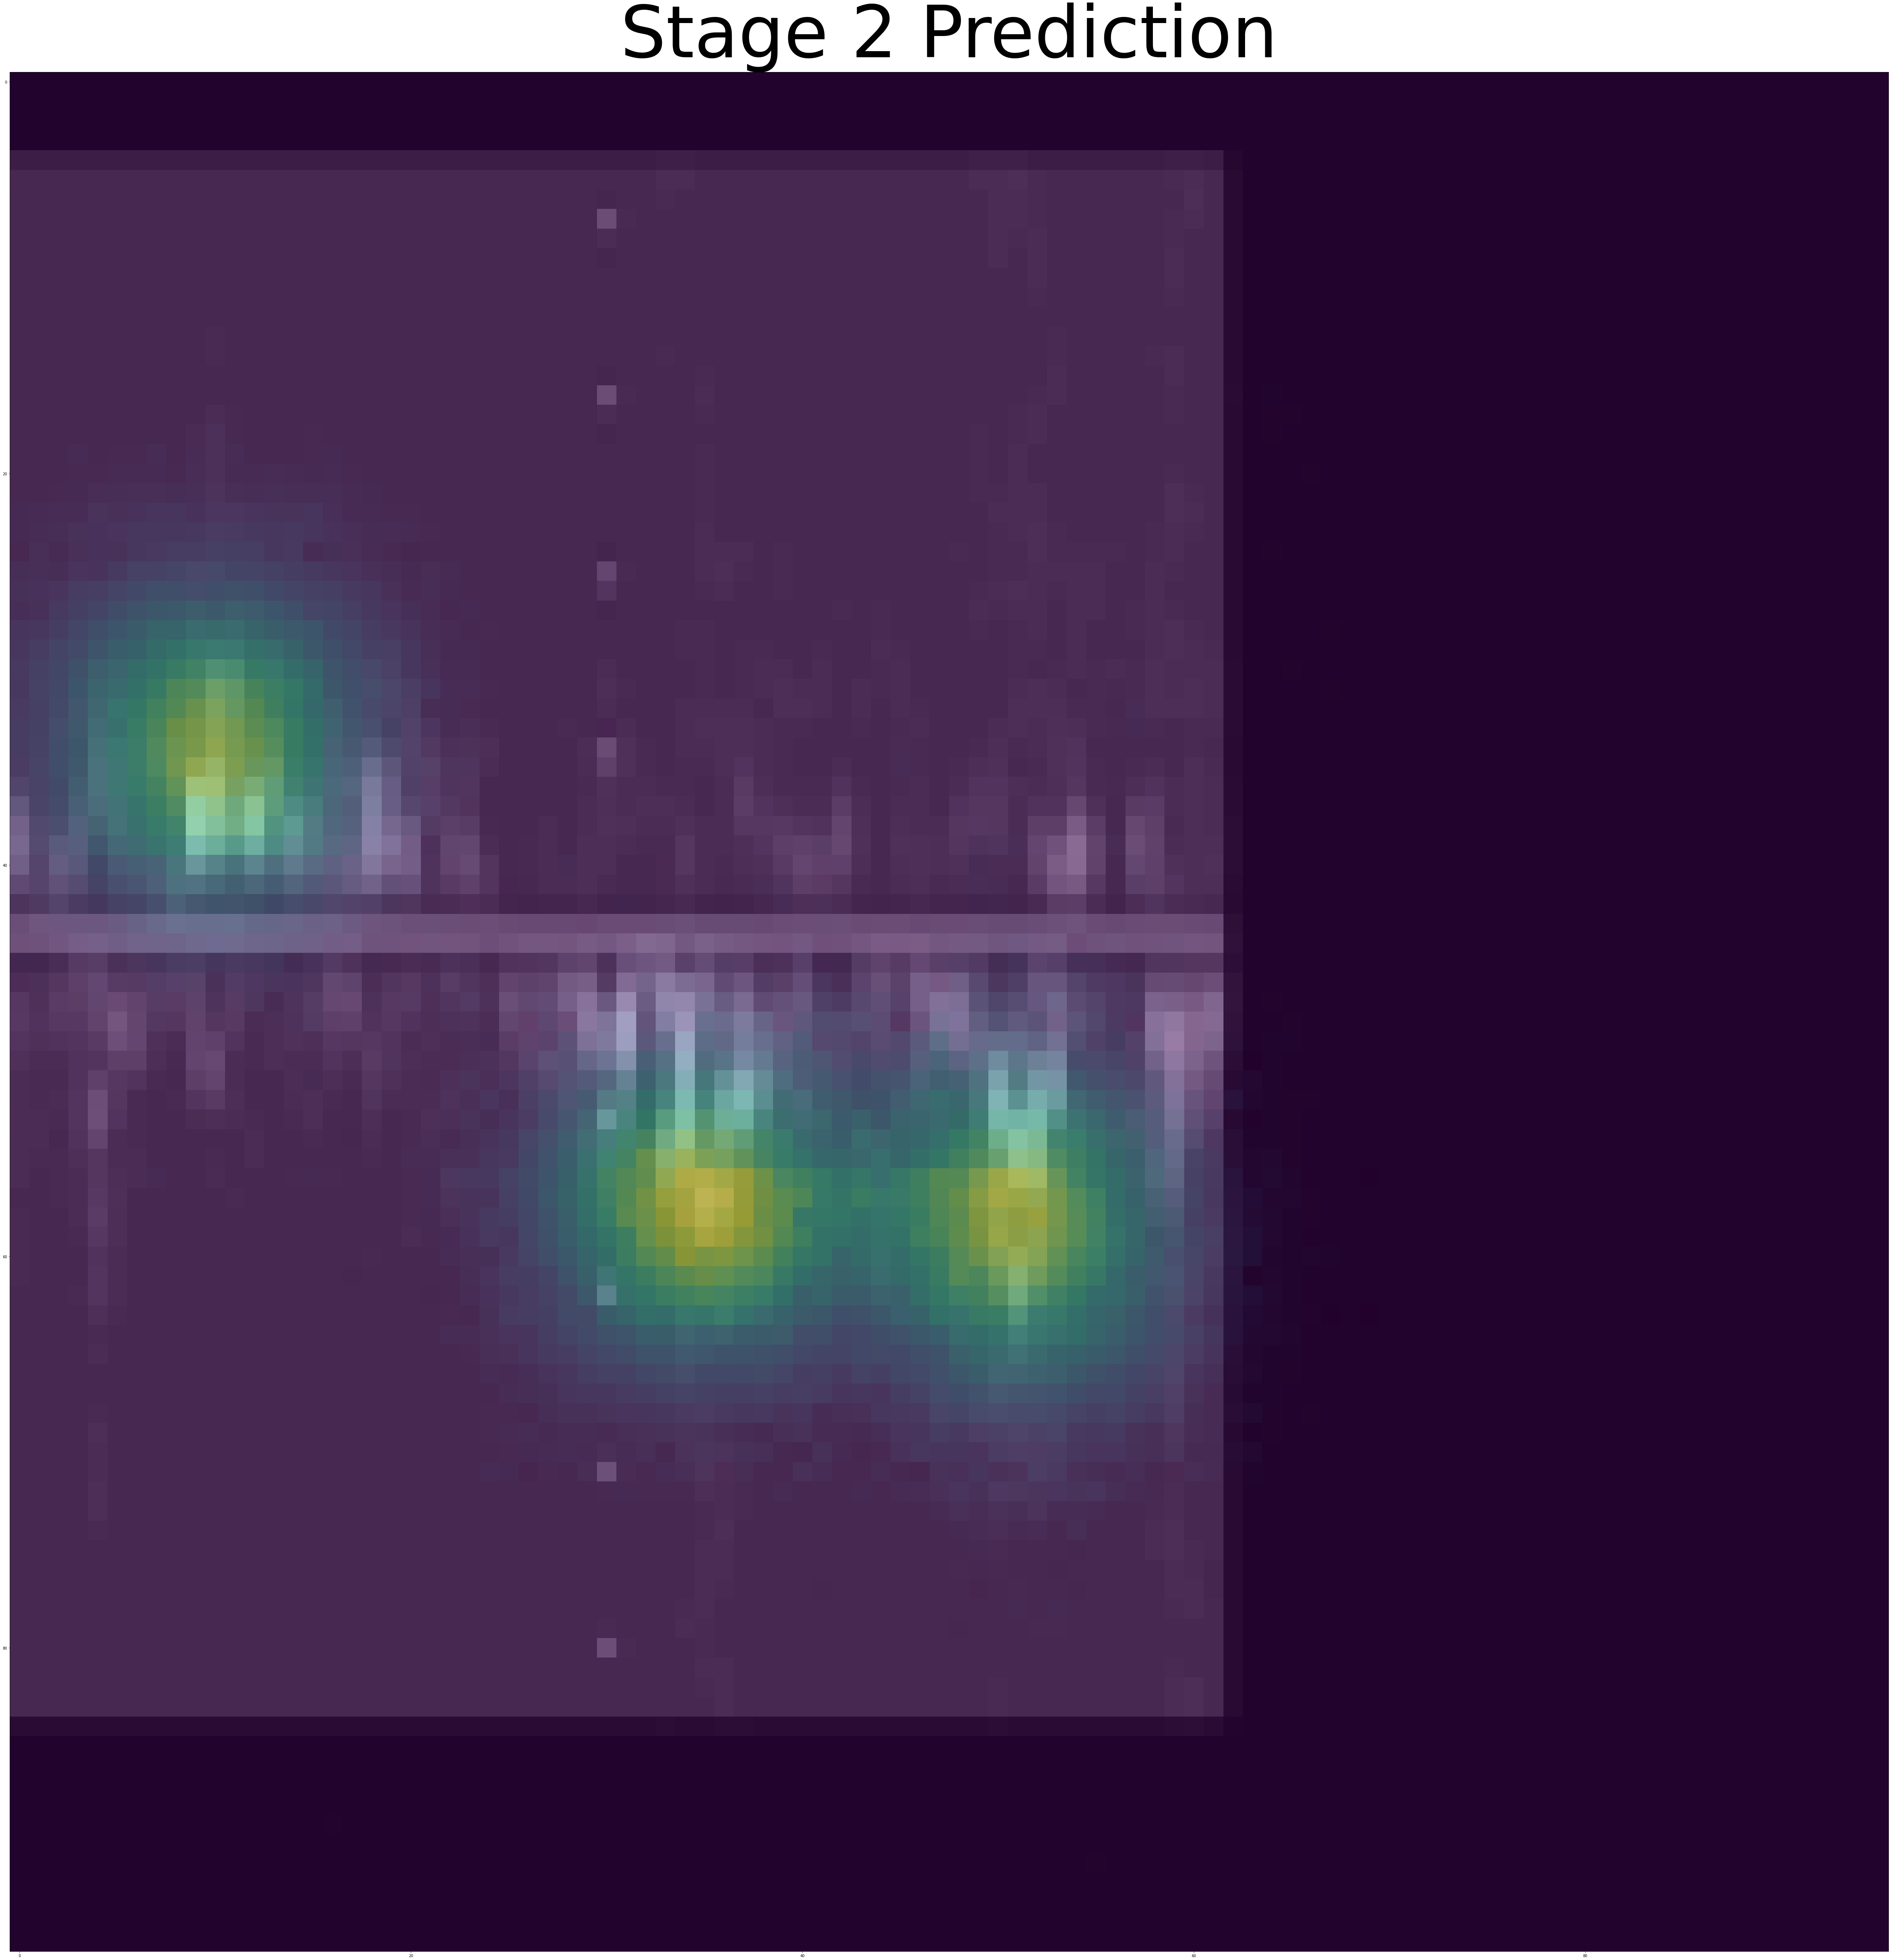

No: 5


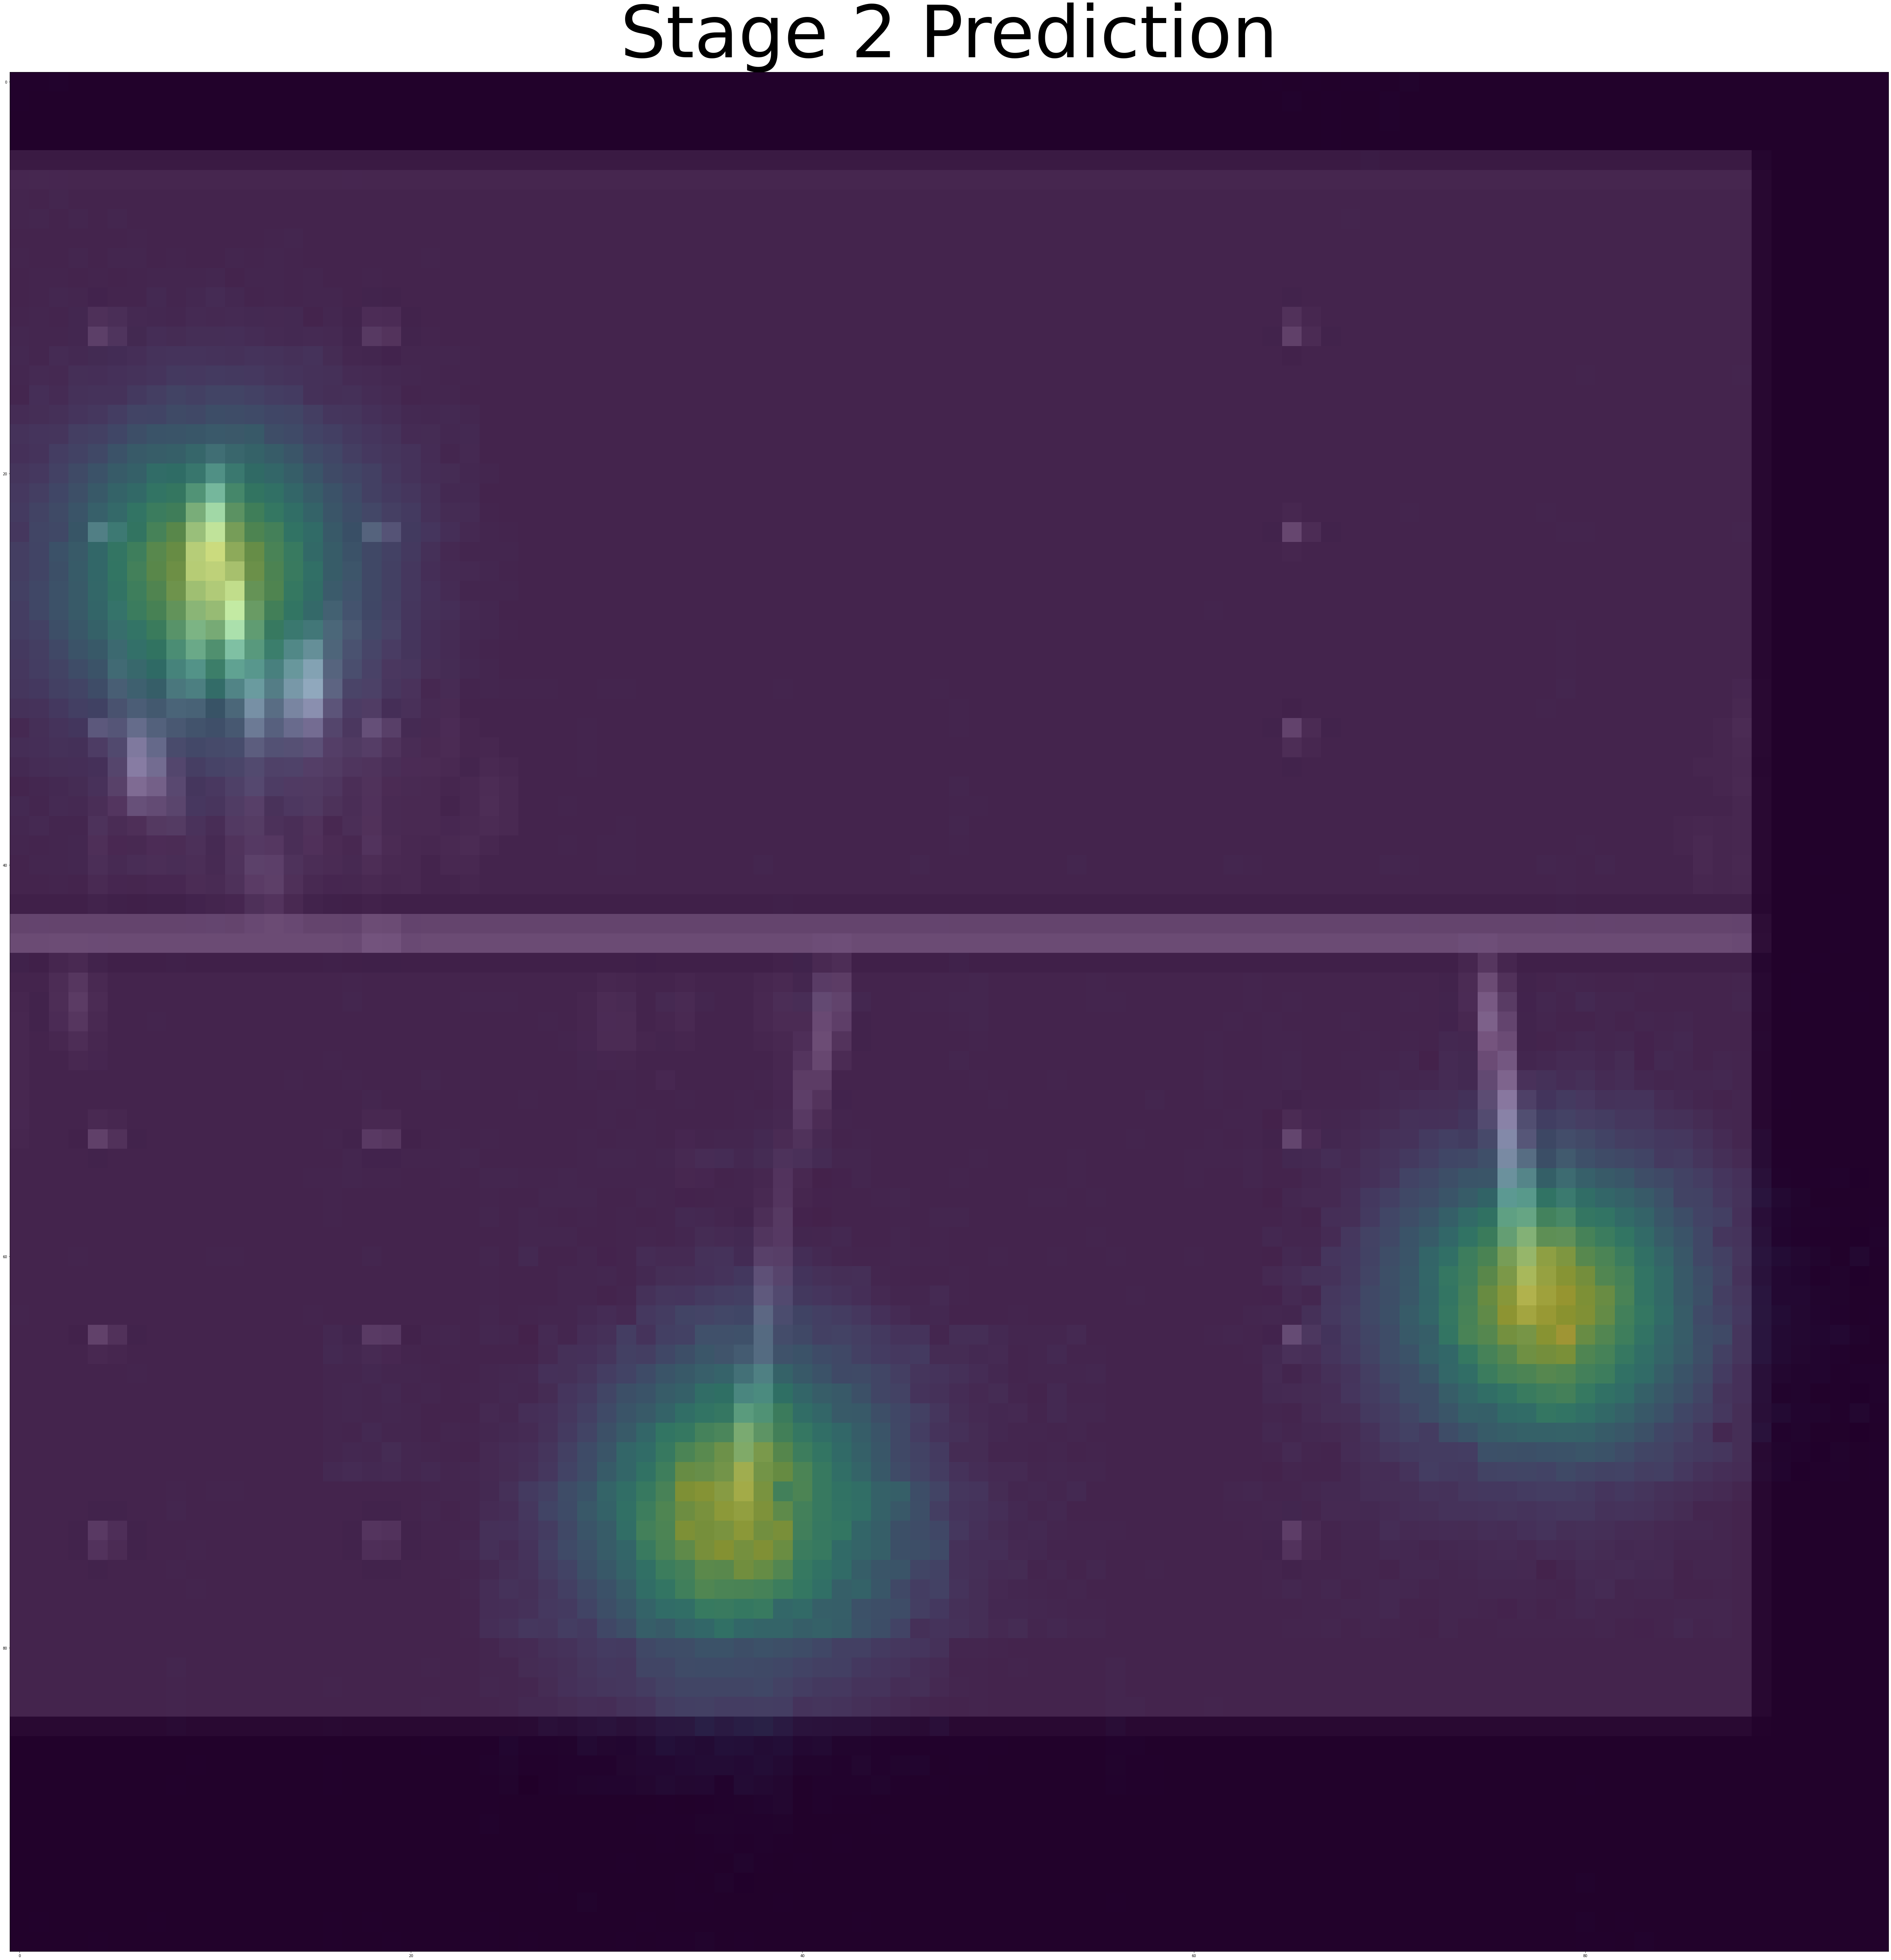

No: 6


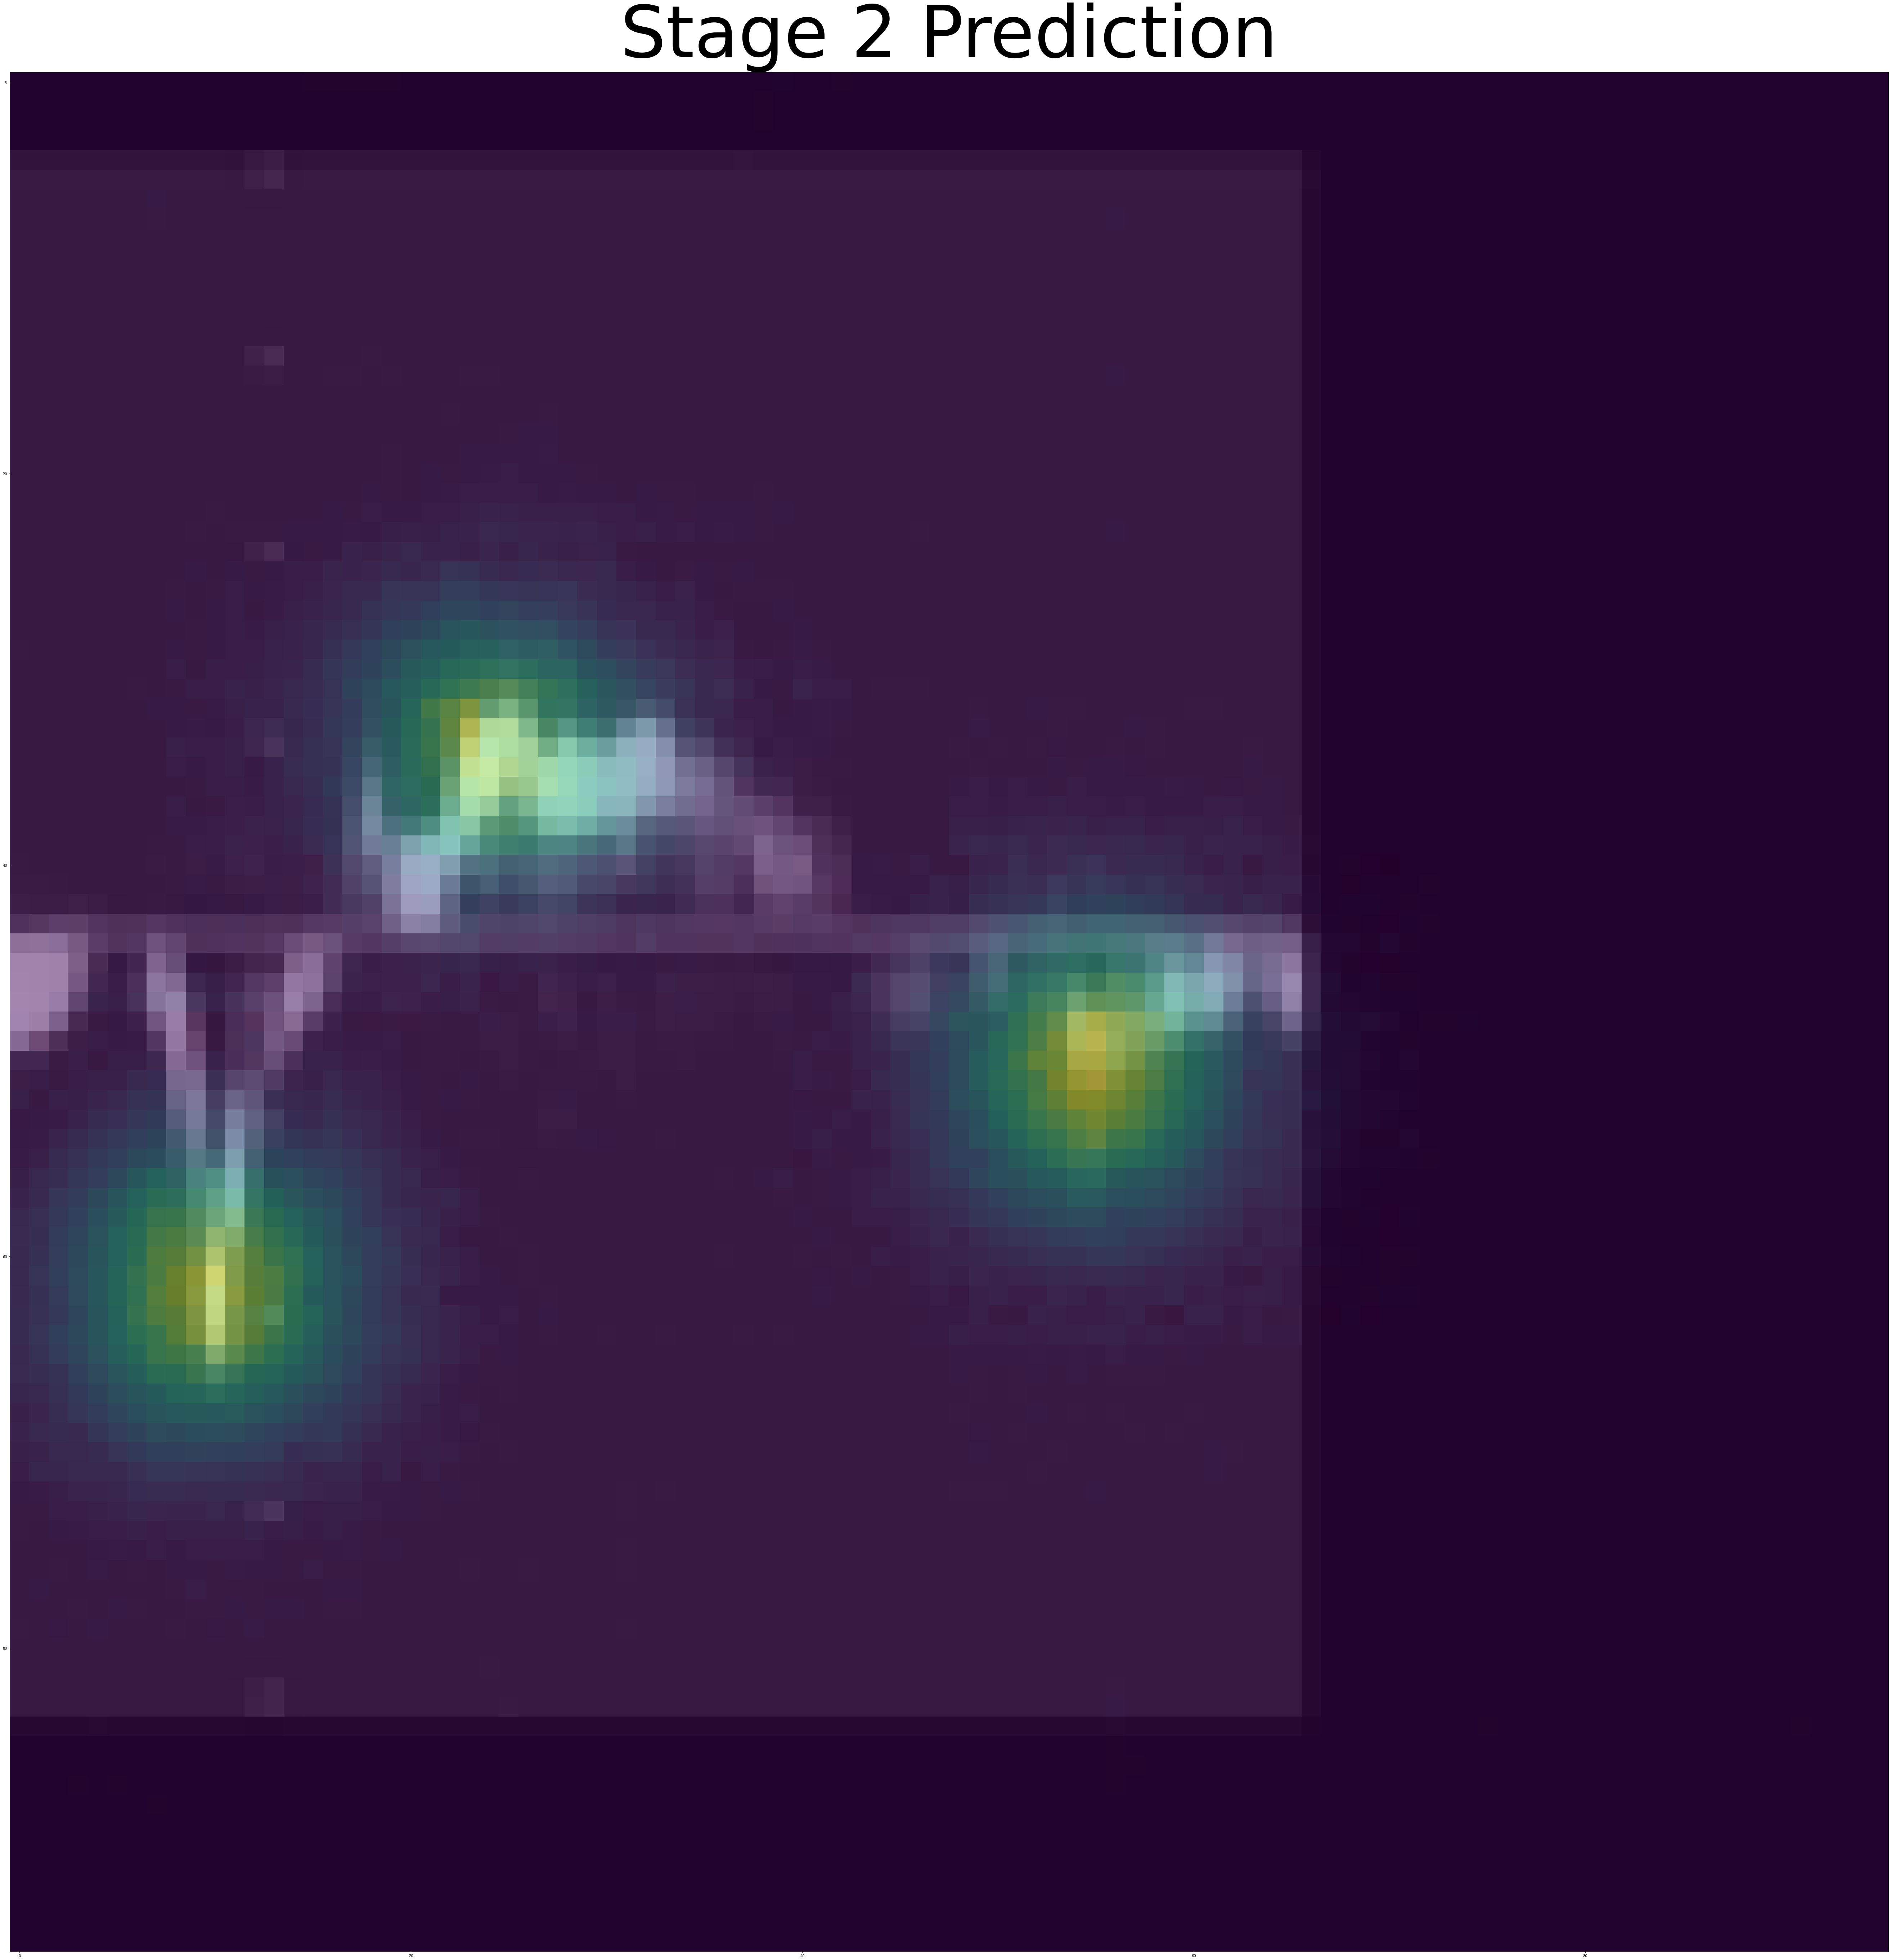

No: 7


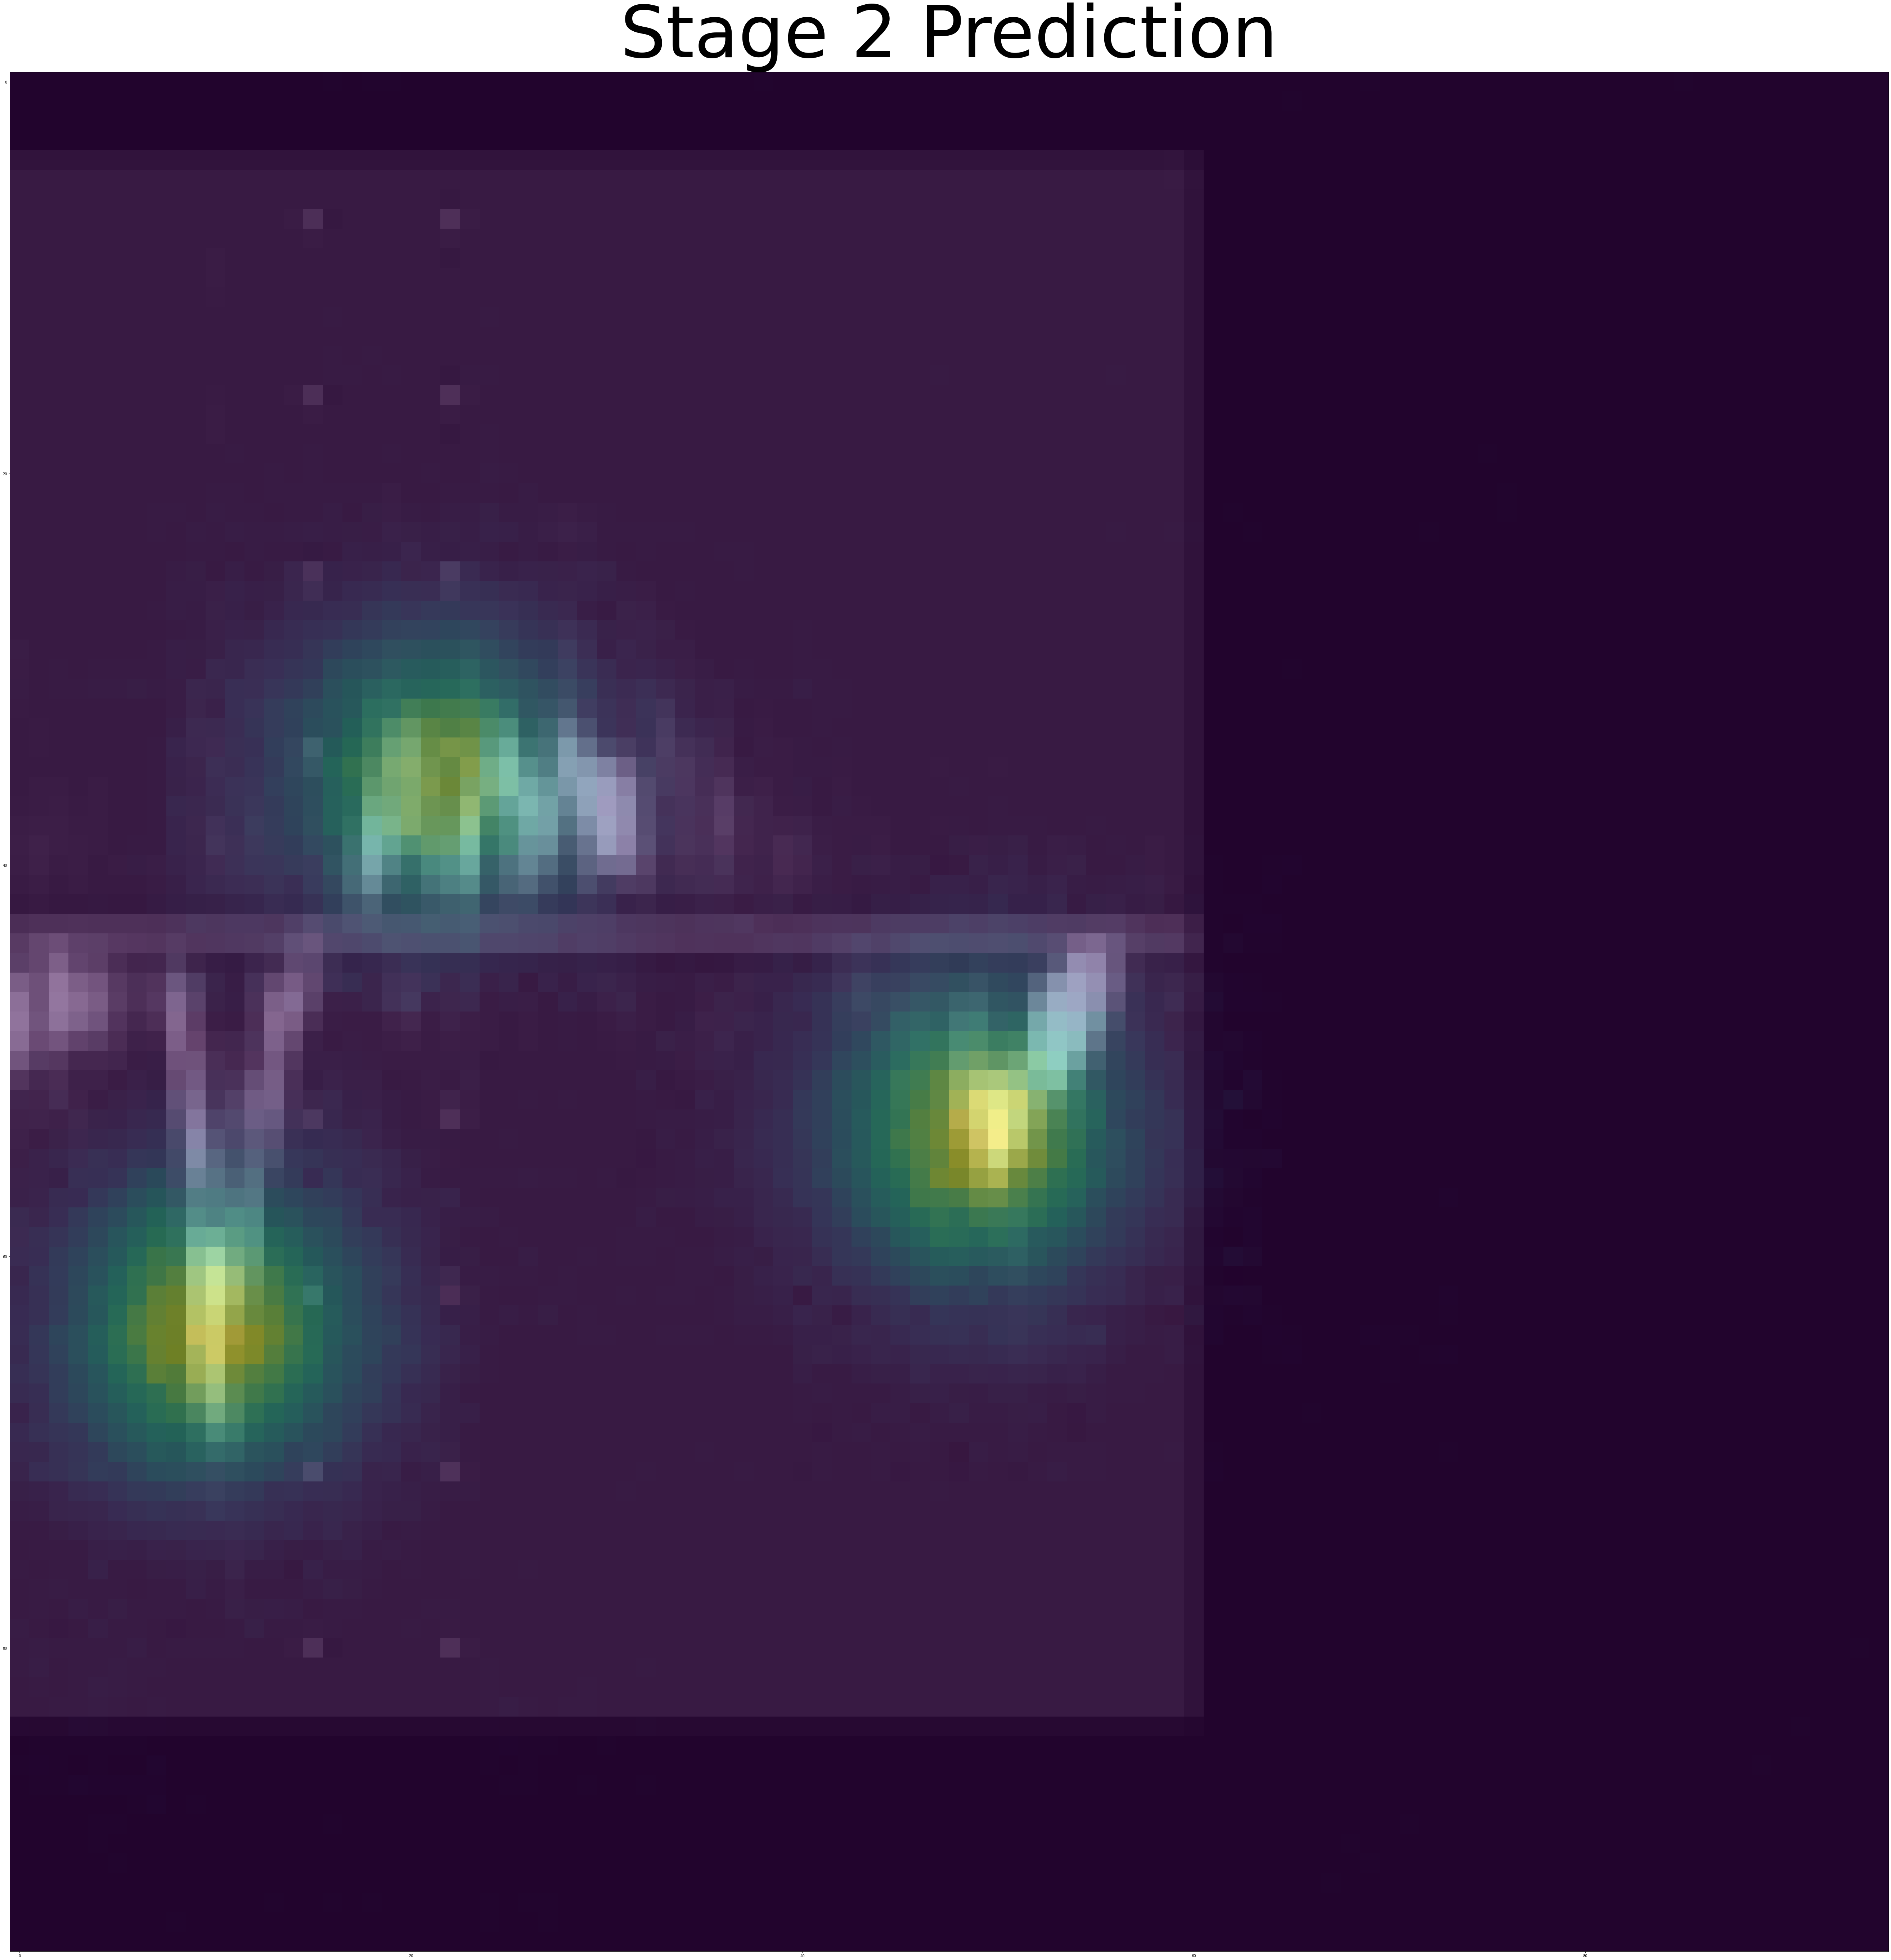

No: 8


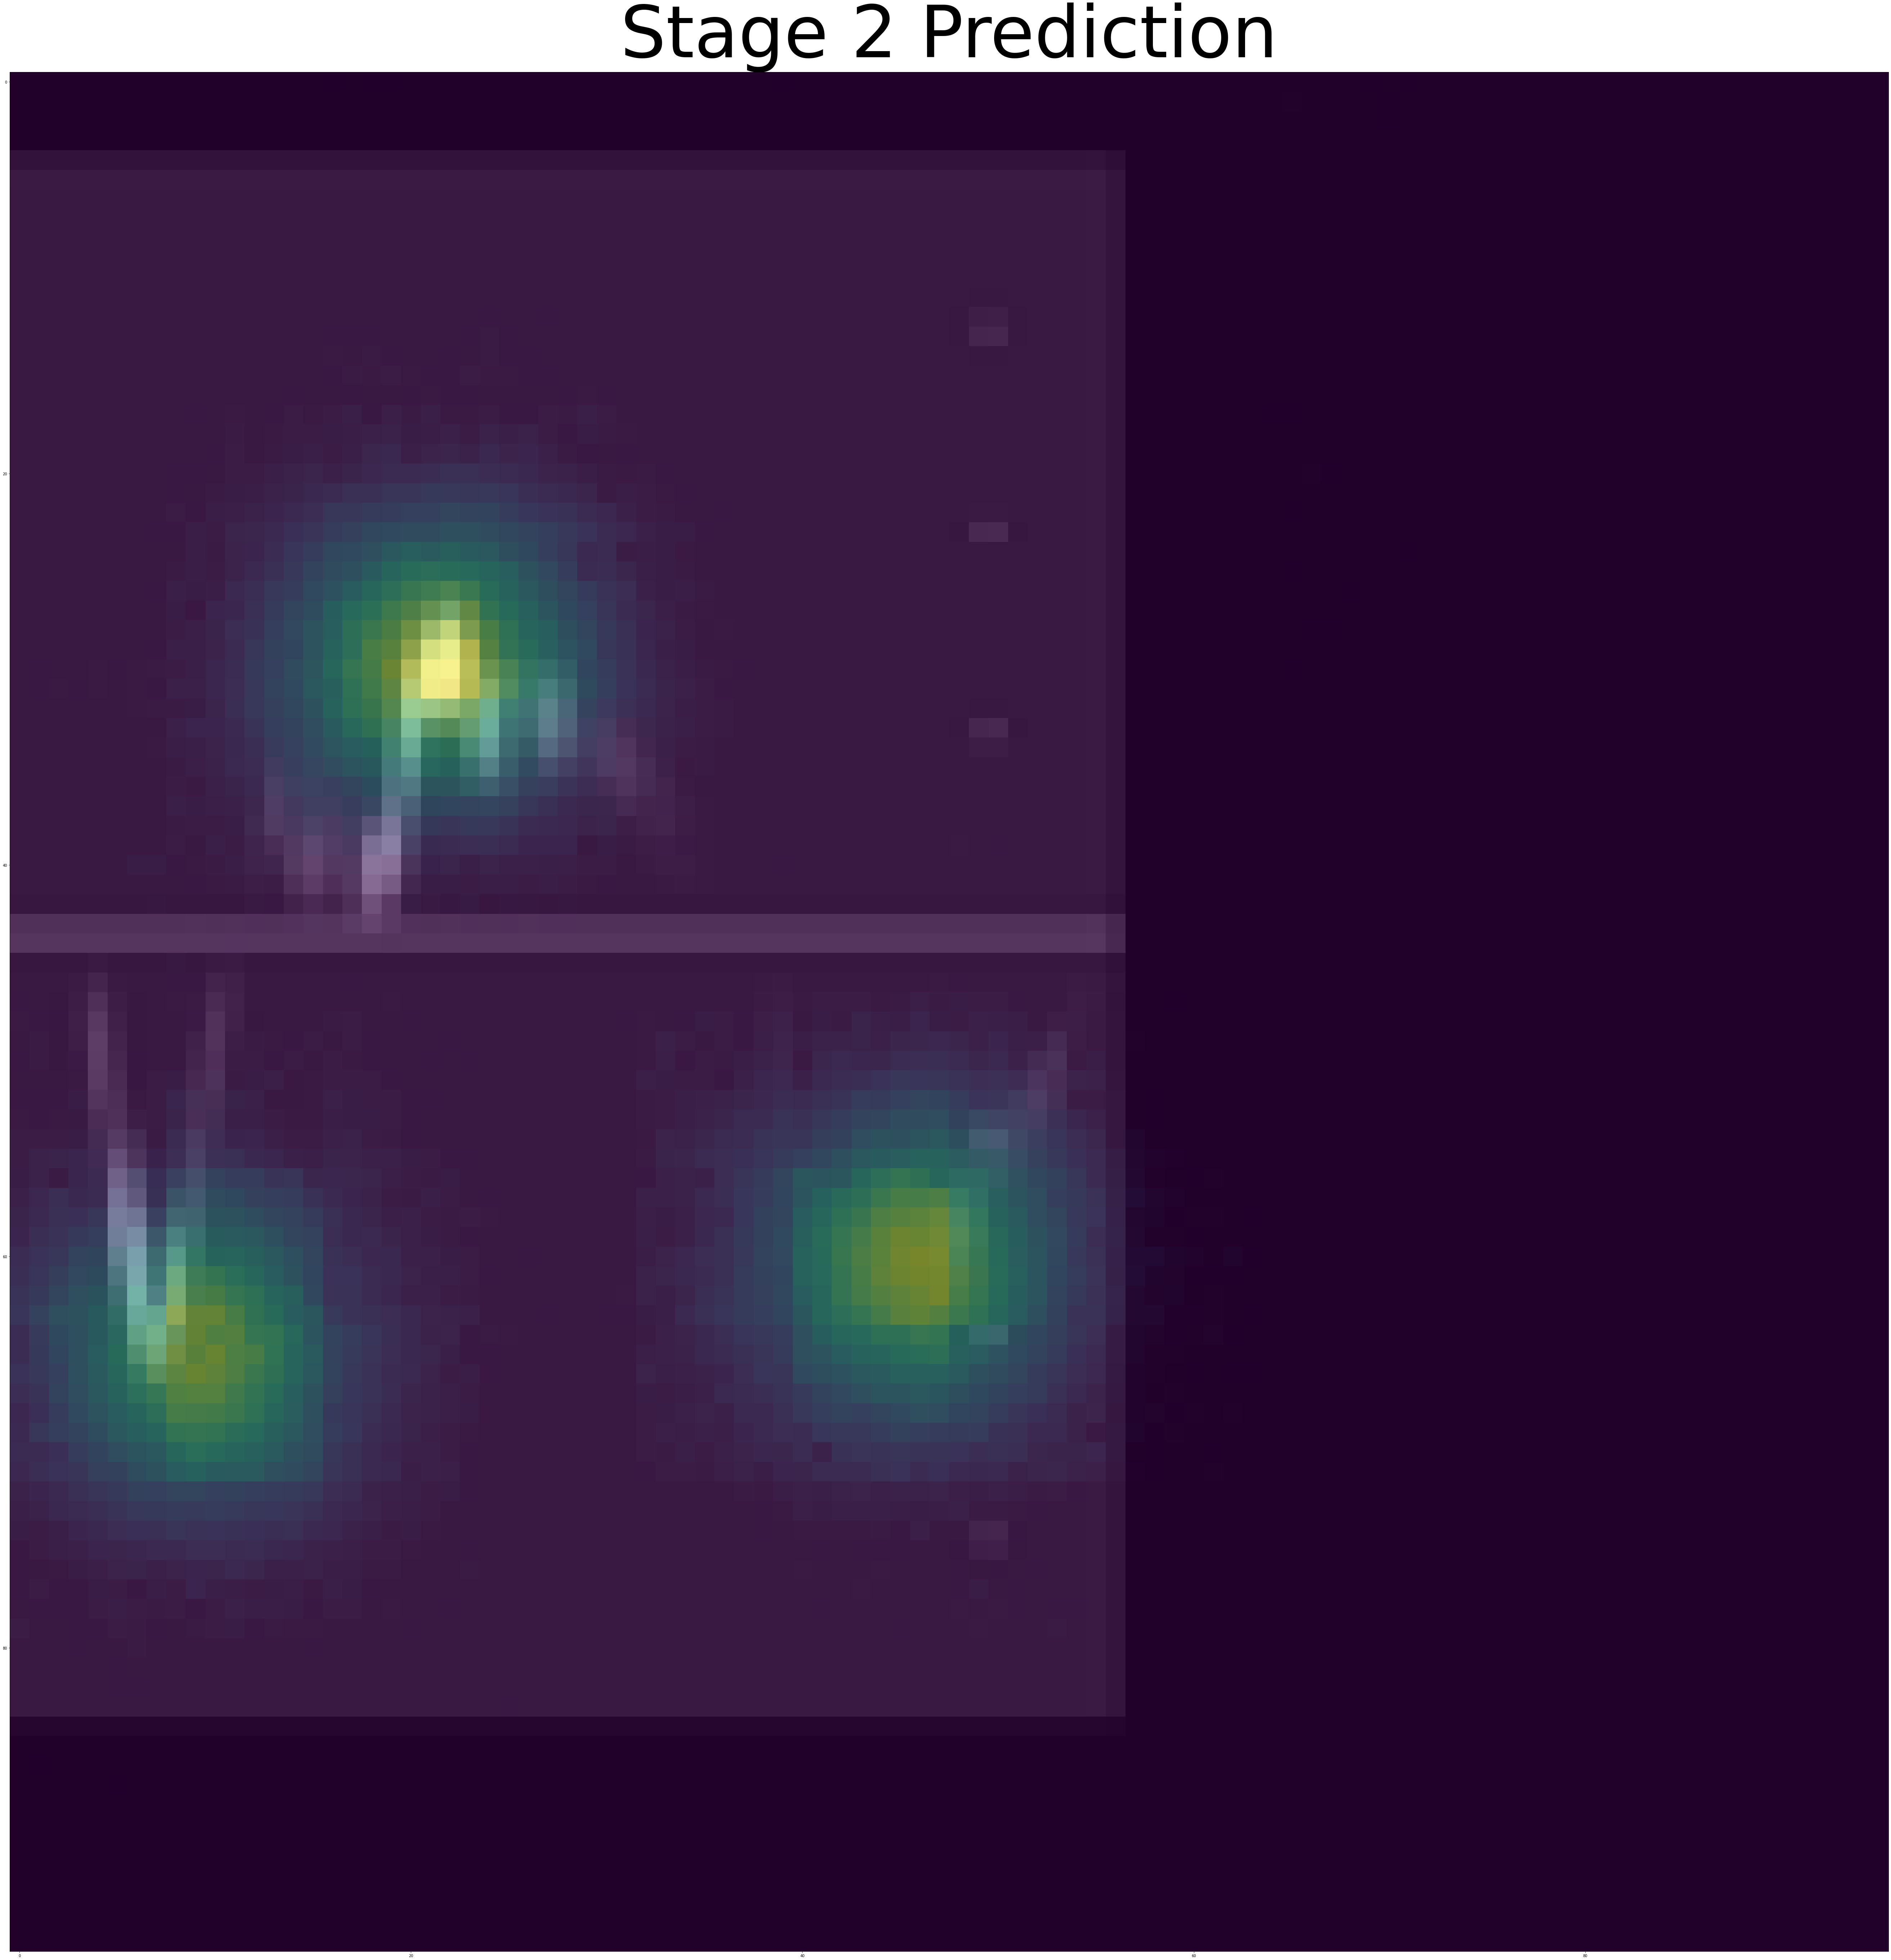

No: 9


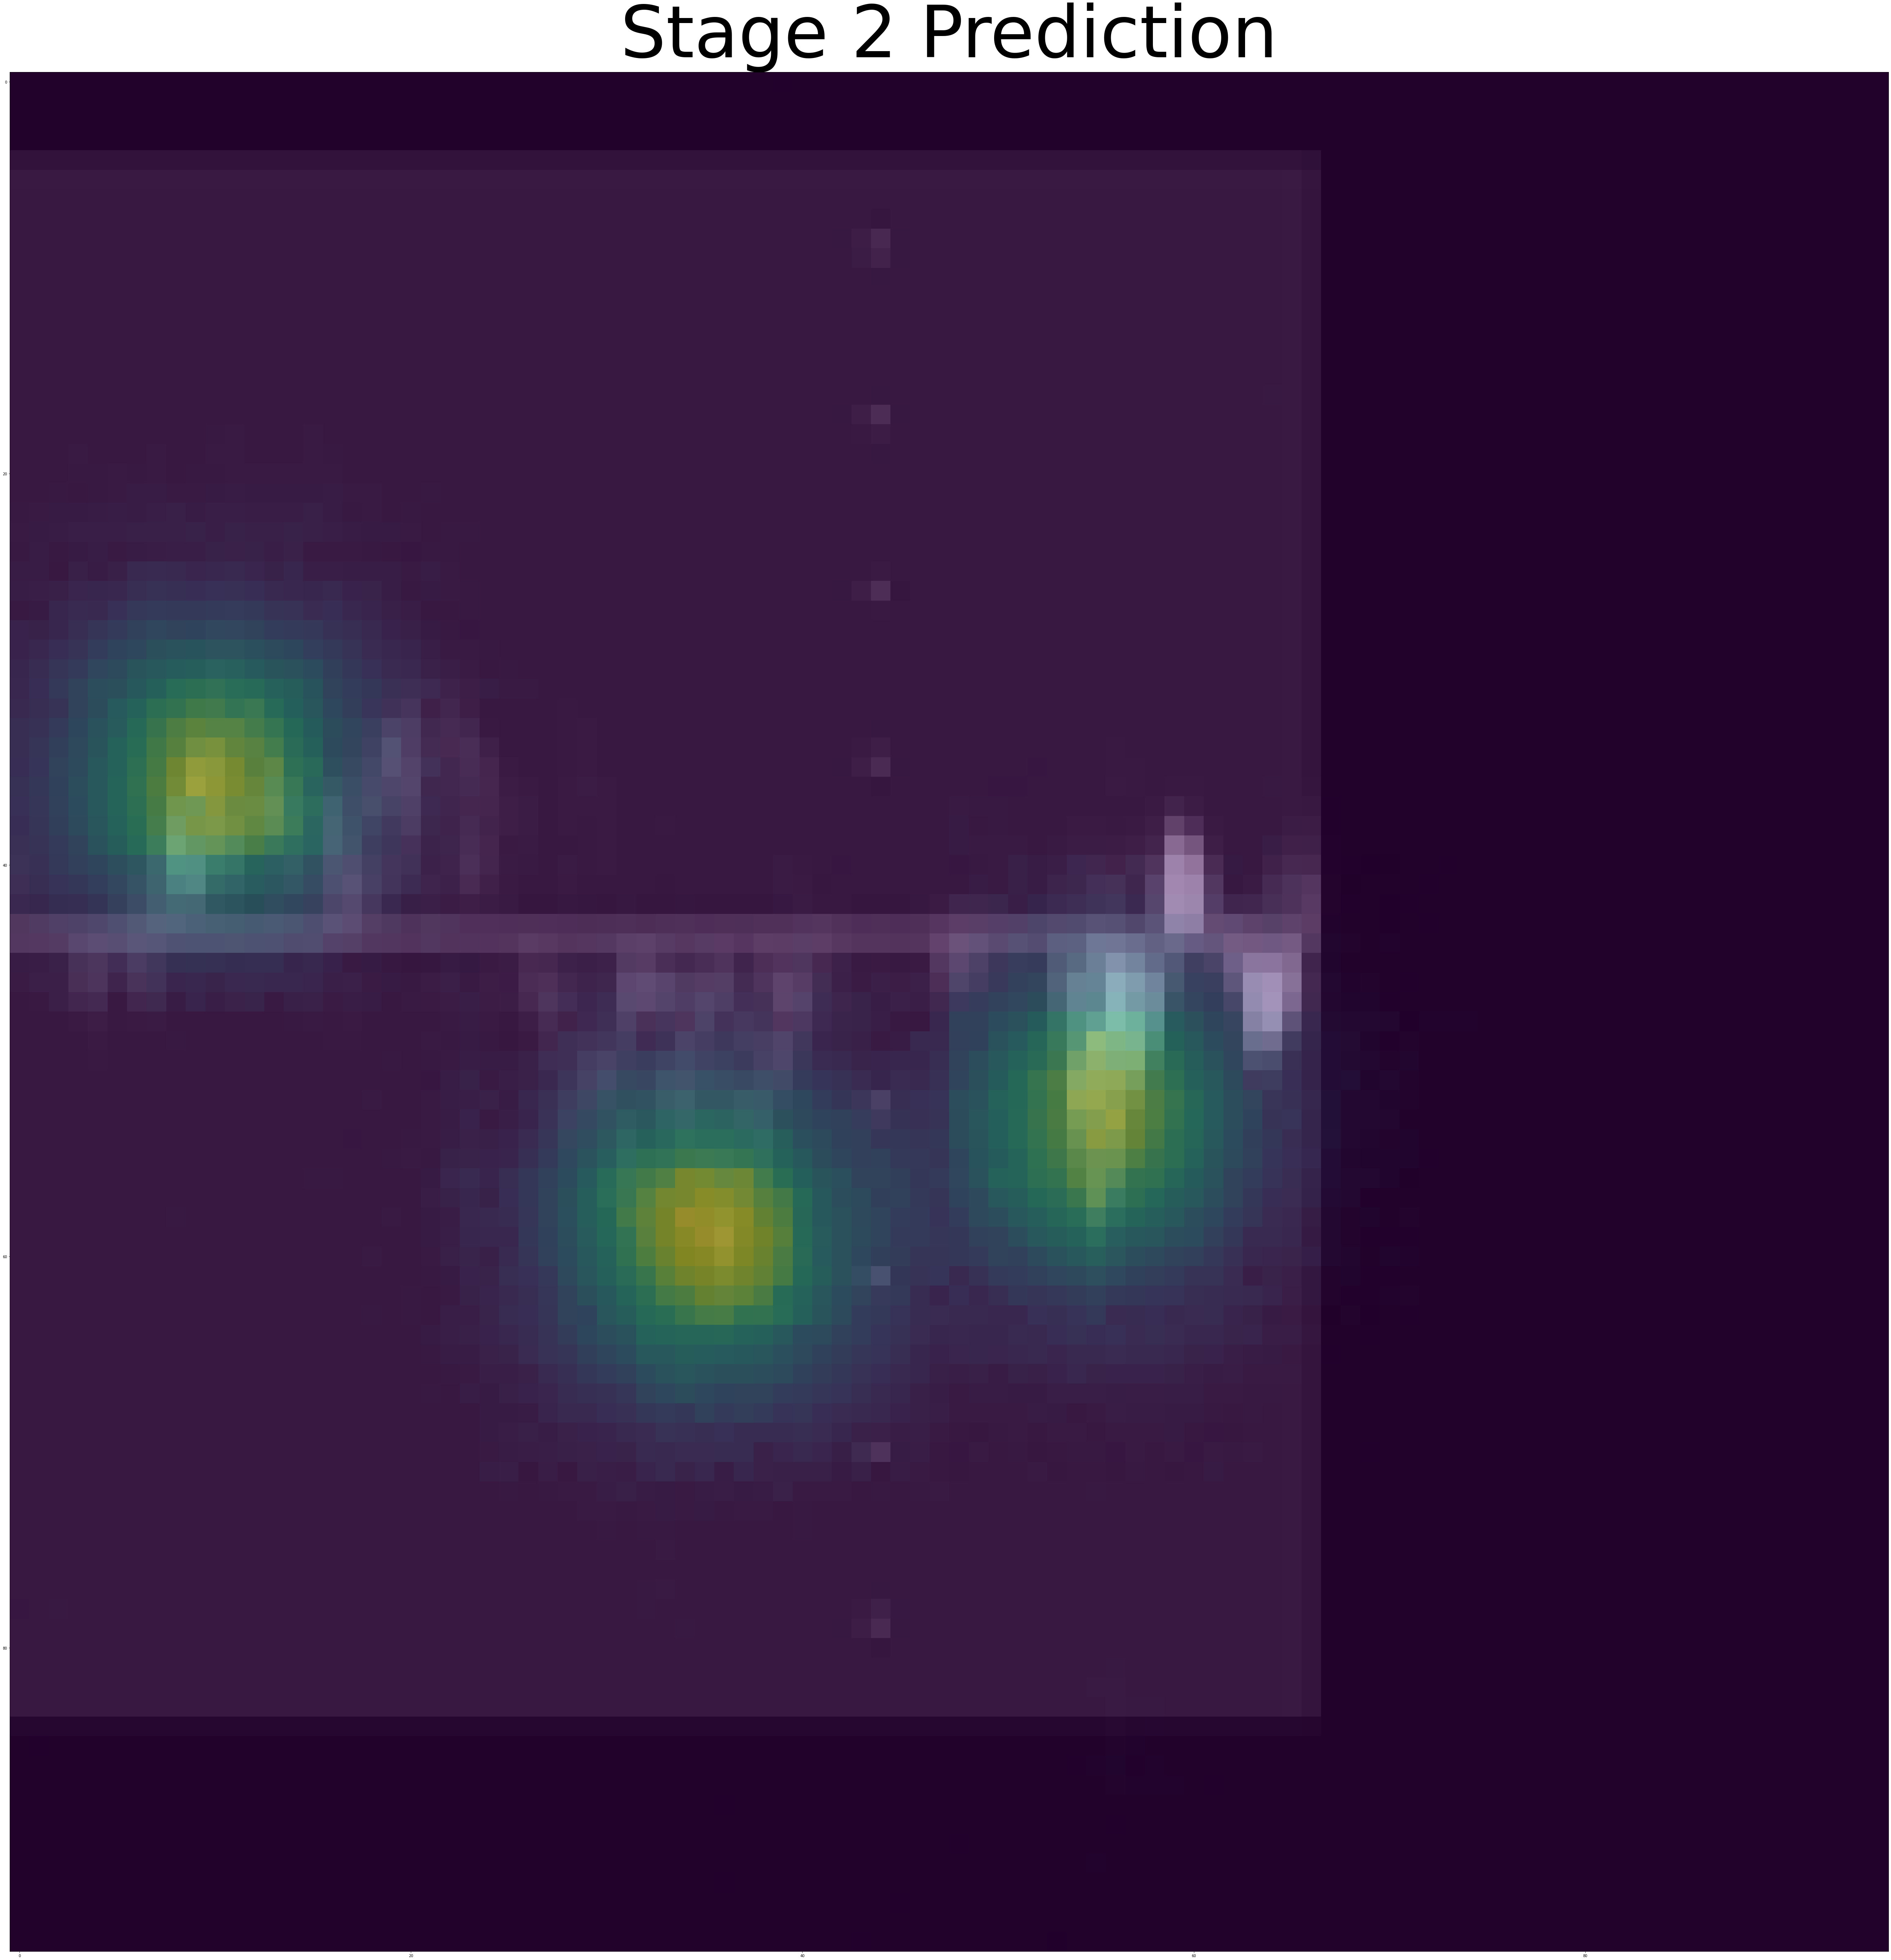

No: 10


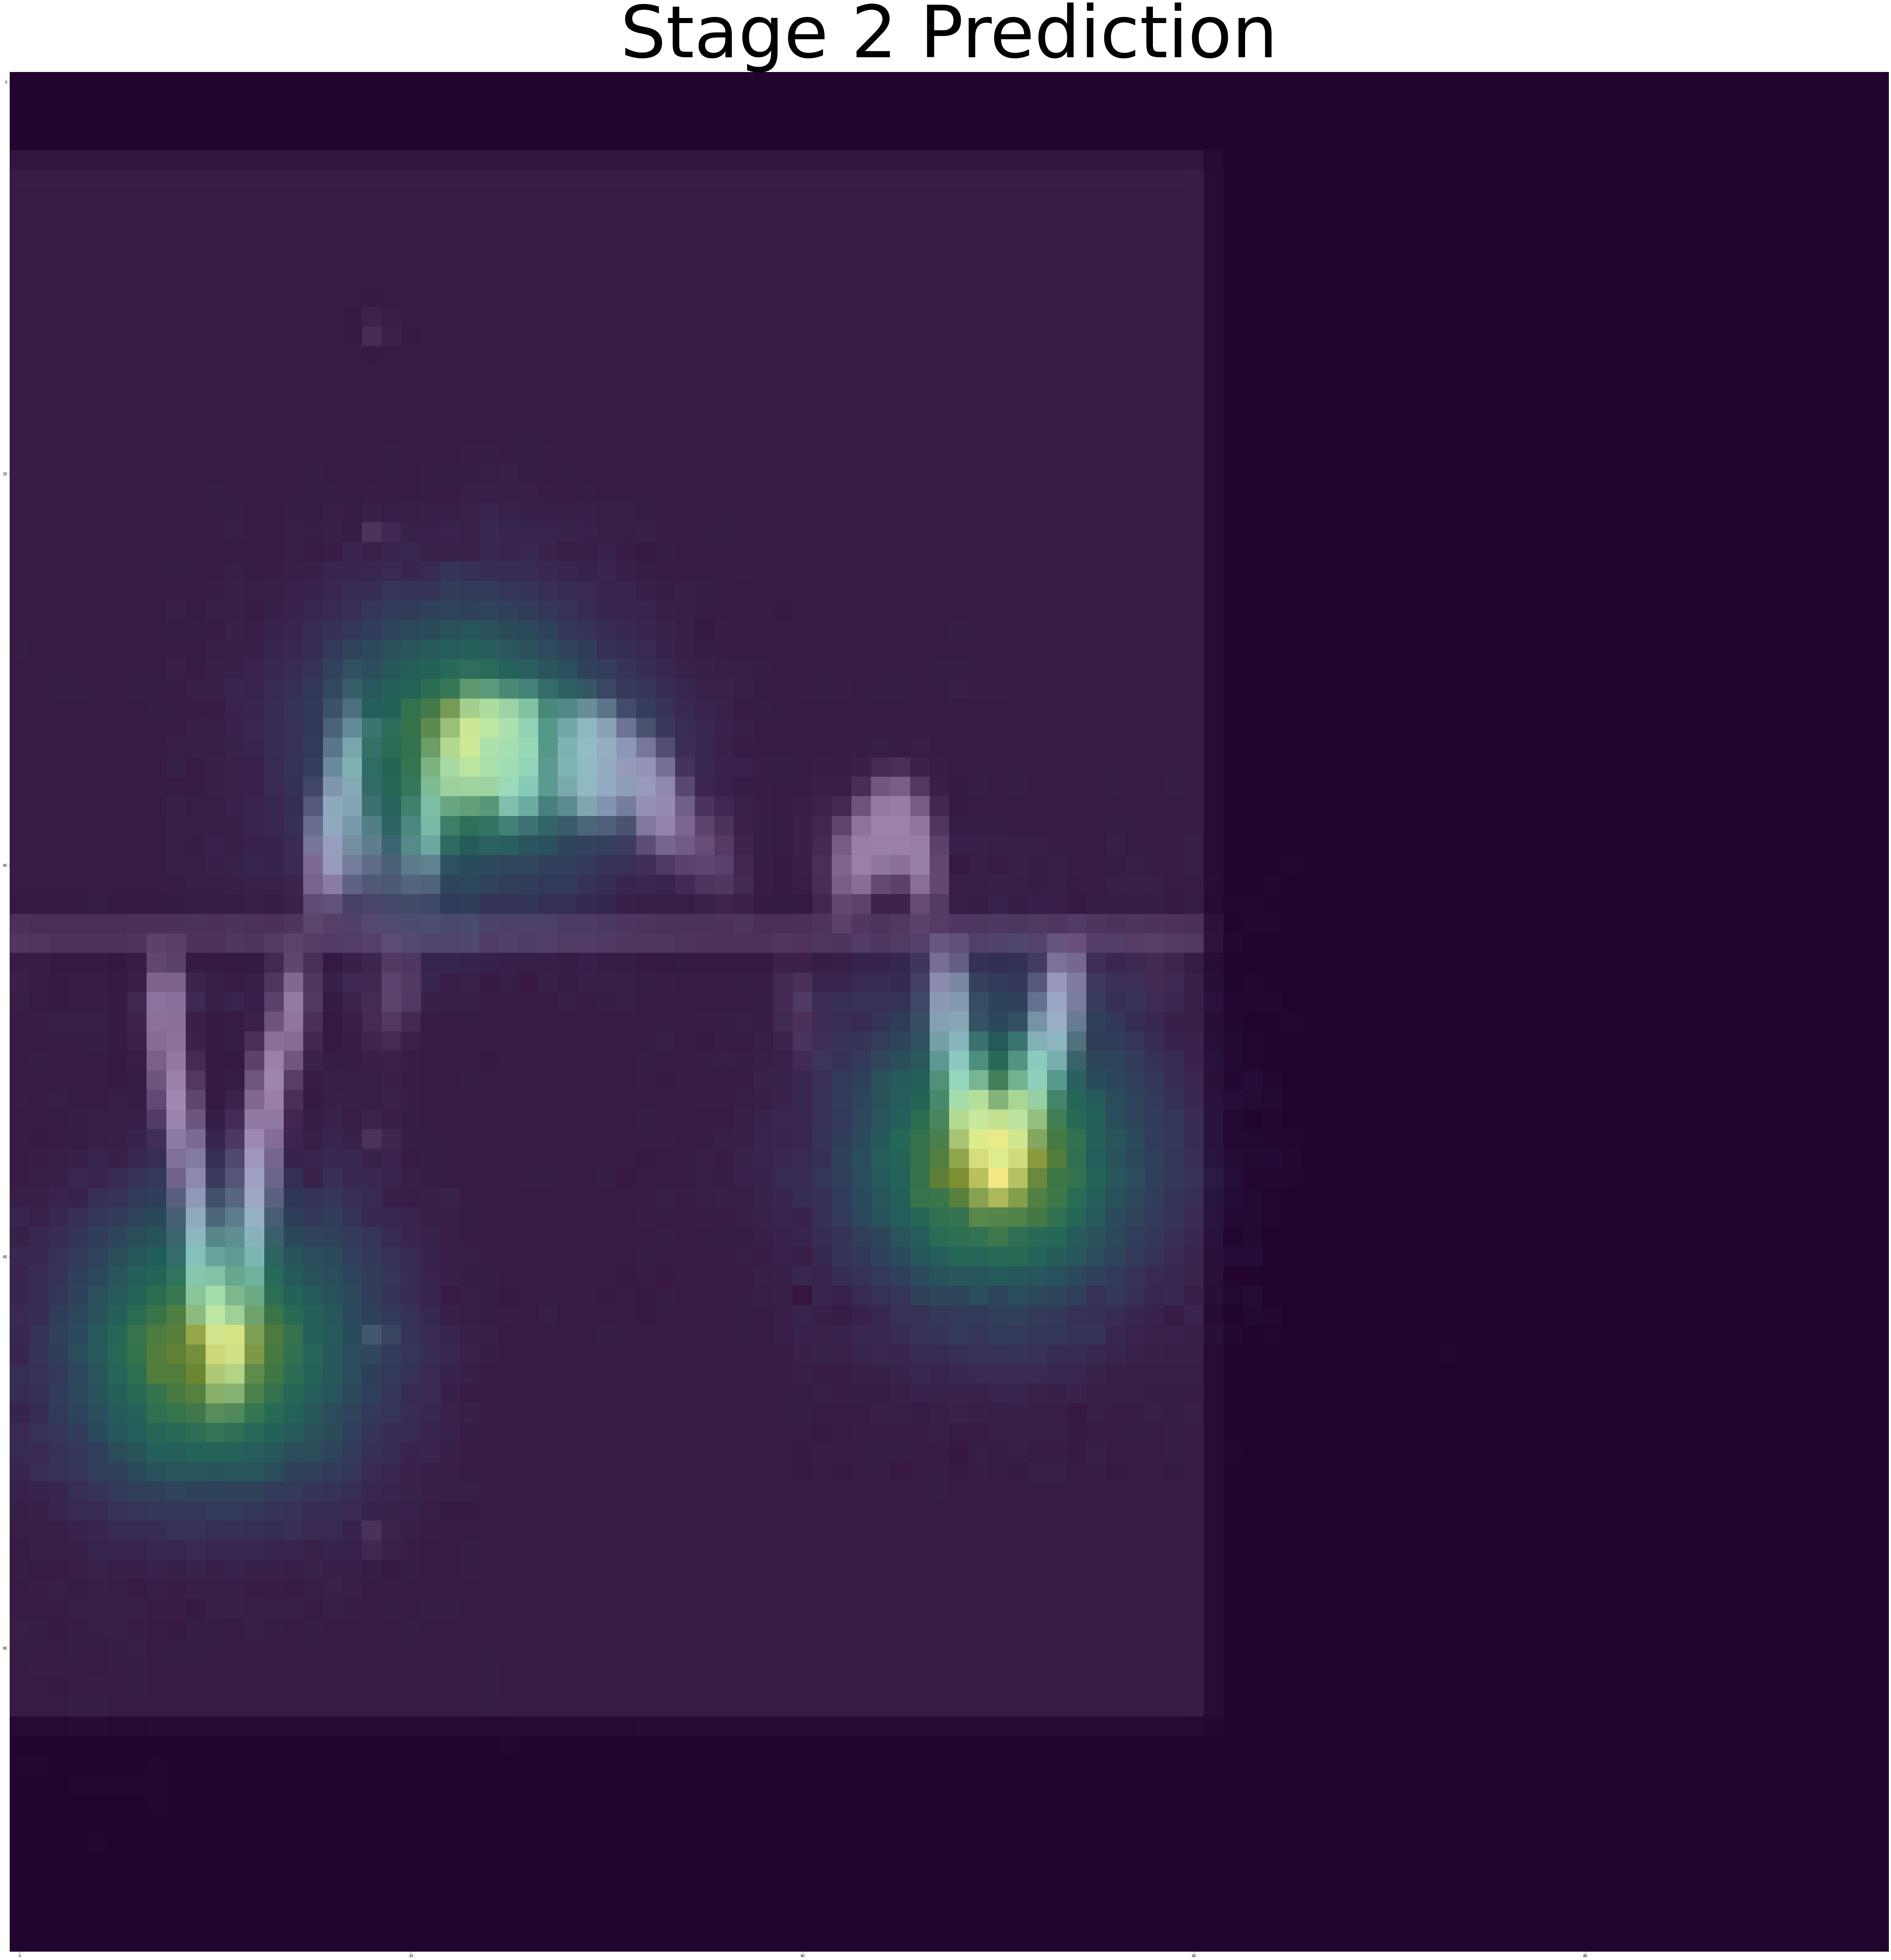

In [ ]:
for i in range(1,11):
  index=i

  predictions = model.predict(X_batch)
  print("No:",i)
  Fontsize = 200

  plt.figure(figsize=(96,96))
  #plt.subplot(1,6,1)
  plt.imshow(y_batch[index].sum(axis=2))
  plt.title("Ground Truth Heatmap", fontsize=Fontsize)
  plt.savefig("/content/gdrive/MyDrive/keypoint/heatmap/Ground Truth Heatmap{0}.jpg".format(i))

  #plt.subplot(1,6,2)
  plt.imshow(predictions[0][index].sum(axis=2))
  plt.title("Stage 1 Prediction", fontsize=Fontsize)
  plt.savefig("/content/gdrive/MyDrive/keypoint/heatmap/Stage_1_Prediction{0}.jpg".format(i))
  #plt.subplot(1,6,3)
  plt.imshow(predictions[1][index].sum(axis=2))
  plt.title("Stage 2 Prediction", fontsize=Fontsize)
  plt.savefig("/content/gdrive/MyDrive/keypoint/heatmap/Stage_2_Prediction{0}.jpg".format(i))



  #Plot an image overlayed with its heatmaps
  #plt.subplot(1,6,4)
  plt.imshow(X_batch[index].reshape(im_w, im_h), cmap='gray')
  plt.imshow(y_batch[index].sum(axis=2), alpha=0.5)
  plt.title("Ground Truth Heatmap", fontsize=Fontsize)
  plt.savefig("/content/gdrive/MyDrive/keypoint/heatmap/GroundTruthHeatmapOverlayed{0}.jpg".format(i))
  
  #plt.subplot(1,6,5)
  plt.imshow(X_batch[index].reshape(im_w, im_h), cmap='gray')
  plt.imshow(predictions[0][index].sum(axis=2), alpha=0.5)
  plt.title("Stage 1 Prediction", fontsize=Fontsize)
  plt.savefig("/content/gdrive/MyDrive/keypoint/heatmap/Stage_1_Prediction_overlayed{0}.jpg".format(i))


  #plt.subplot(1,6,6)
  plt.imshow(X_batch[index].reshape(im_w, im_h), cmap='gray')
  plt.imshow(predictions[1][index].sum(axis=2), alpha=0.5)
  plt.title("Stage 2 Prediction", fontsize=Fontsize)
  plt.savefig("/content/gdrive/MyDrive/keypoint/heatmap/Stage_2_Prediction_overlayed{0}.jpg".format(i))

  plt.show()

TypeError: ignored

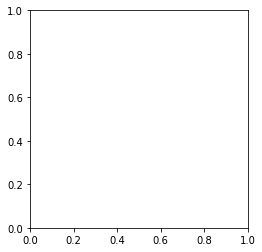

In [ ]:
plt.imshow("/content/gdrive/MyDrive/keypoint/heatmap1.png")

In [ ]:
hist=model.history

In [ ]:
hist.history['output_stage1_loss']

KeyError: ignored